In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
import numpy as np
from scipy import stats, spatial
import processing

In [3]:
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
import statsmodels.api as sm

In [4]:
words = pd.read_csv('./data/words.csv')

In [9]:
log = pd.read_csv('./data/log_valid_processed.csv')

In [11]:
participants = pd.read_csv('./data/participants_processed.csv',index_col=0)
participants = participants.loc[participants.index.isin(log.participant_id.unique())].copy()

## Performance analysis

#### Data prep

In [502]:
mask = words.ite == 'none'
mask &= words.word_length < 5
mask &= words.freq_category == 'very_common'
mask &= words.iki_letters.notna()

participants['iki_natural'] = words.loc[mask].groupby('participant_id').iki_letters.mean()

mask = words.ite == 'none'
participants['iki_letters'] = words.loc[mask].groupby('participant_id').iki_letters.mean()
participants['iki_letters_and_ite'] = words.groupby('participant_id').iki_letters_and_ite.mean() 
iki_overall = log.groupby(['participant_id','ts_id']).iki.sum() / log.groupby(['participant_id','ts_id']).text_field.last().str.len()
iki_overall = iki_overall.reset_index(name='iki').groupby('participant_id').iki.mean()
participants['iki_overall'] = iki_overall

# Remove NA speeds
participants = participants.dropna(subset=['iki_natural','iki_letters','iki_letters_and_ite','iki_overall']).copy()

# Remove extremely fast speeds (due to bad filtering)
participants = participants.loc[participants.iki_natural > 75].copy()

participants['n_predict'] = words.groupby('participant_id').ite.value_counts().unstack()['predict'].fillna(0)
participants['rate_predict'] = words.groupby('participant_id').ite.value_counts(normalize=True).unstack()['predict'].fillna(0)

participants['rate_completion'] = words.loc[
    words.ite == 'predict'
].groupby('participant_id').ite2.value_counts(normalize=True).unstack()['completion']

participants['rate_correction'] = words.loc[
    words.ite == 'predict'
].groupby('participant_id').ite2.value_counts(normalize=True).unstack()['correction']

# Calculate keystrokes per character
mask = log.lev_dist < 10 # Filter out poor LD calculations
participants['KPC'] = log.loc[mask].groupby('participant_id').size() / log.loc[mask].groupby('participant_id').lev_dist.sum()

# Group participants
participants.loc[participants.n_predict < 1,'user_type'] = 'Normal'
participants.loc[participants.n_predict > 5,'user_type'] = 'Suggestion users'

In [503]:
participants.user_type.value_counts()

Suggestion users    2615
Normal              2294
Name: user_type, dtype: int64

#### What is the mean natural speed?

In [1121]:
participants.groupby('user_type').iki_natural.mean().apply(np.reciprocal)*1000

user_type
Normal              5.424126
Suggestion users    4.753959
Name: iki_natural, dtype: float64

#### Controlling for natural speed, what is the difference in overall speed?

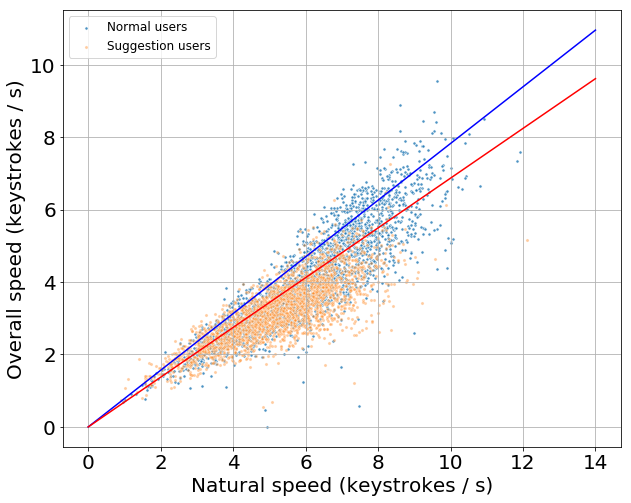

In [1134]:
f,ax = plt.subplots(1,1,figsize=(10,10))

mask = participants.n_predict < 1
sns.scatterplot(
    participants.loc[mask].iki_natural.apply(np.reciprocal)*1000,
    participants.loc[mask].iki_overall.apply(np.reciprocal)*1000,
    s = 10,
    alpha = 0.8,
    label = 'Normal users',
    ax=ax
)
model1 = sm.OLS(participants.loc[mask].iki_overall.apply(np.reciprocal)*1000, participants.loc[mask].iki_natural.apply(np.reciprocal)*1000).fit()
sns.lineplot(
    x = [0,14],
    y = [0*model1.params[0],16*model1.params[0]],
    color = 'b',
    ax=ax
)

mask = participants.n_predict > 5
sns.scatterplot(
    participants.loc[mask].iki_natural.apply(np.reciprocal)*1000,
    participants.loc[mask].iki_overall.apply(np.reciprocal)*1000,
    s = 10,
    alpha = 0.4,
    label = 'Suggestion users',
    ax=ax
)
model2 = sm.OLS(participants.loc[mask].iki_overall.apply(np.reciprocal)*1000, participants.loc[mask].iki_natural.apply(np.reciprocal)*1000).fit()
sns.lineplot(
    x = [0,14],
    y = [0*model2.params[0],16*model2.params[0]],
    color = 'r',
    ax=ax
)

ax.set_xlabel('Natural speed (keystrokes / s)')
ax.set_ylabel('Overall speed (keystrokes / s)')
ax.set_aspect('equal')
ax.legend(fontsize='large')
ax.grid()


for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

f.savefig('./figures/regression_kps_normal_v_predict.png', dpi=300)

In [1135]:
model1.params[0],model2.params[0]

(0.6845141159984833, 0.6007813063755758)

In [1136]:
model2.params[0] / model1.params[0]

0.8776755545782009

#### How does the extent of suggestion usage affect the typing speed?

In [140]:
data = participants.loc[participants.n_predict > 5][['iki_natural','rate_predict','iki_letters']].dropna().copy()
data.iki_natural = data.iki_natural.apply(np.reciprocal)*1000
data.iki_letters = data.iki_letters.apply(np.reciprocal)*1000
data.rate_predict = data.rate_predict.apply(np.reciprocal)

X_train =  data[['iki_natural','rate_predict']].copy()
# X_train = preprocessing.StandardScaler().fit_transform(X_train)
X_train = pd.DataFrame(X_train,index=data.index,columns=['iki_natural','rate_predict'])
y_train = data[['iki_letters']]
# y_train = preprocessing.StandardScaler().fit_transform(y_train)



model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            iki_letters   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 1.932e+05
Date:                Mon, 26 Aug 2019   Prob (F-statistic):               0.00
Time:                        14:52:29   Log-Likelihood:                -1171.6
No. Observations:                2616   AIC:                             2347.
Df Residuals:                    2614   BIC:                             2359.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
iki_natural      0.7709      0.004    210.597      0.000       0.764       0.778
rate_predict     0.0343      0.002     22.232      0.000       0.031       0.037
==============================================================================
Omnibus:                     1052.353   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15269.018
Skew:                          -1.502   Prob(JB):                         0.00
Kurtosis:                      14.448   Cond. No.                         7.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

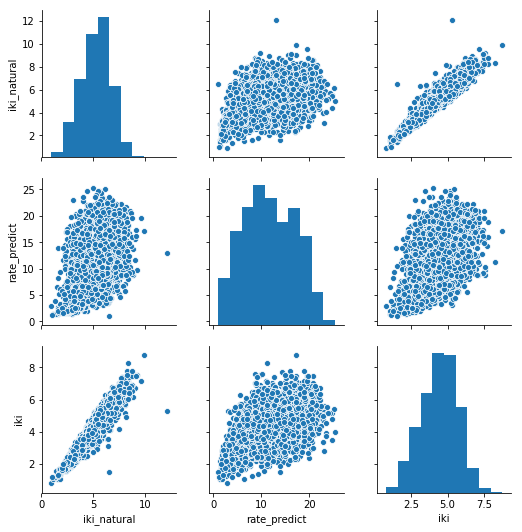

In [307]:
sns.pairplot(data)

In [713]:
participants.loc[participants.n_predict > 5].shape

(2616, 50)

In [714]:
participants.shape

(8945, 50)

In [316]:
model.bse

iki_natural     0.005023
rate_predict    0.002120
dtype: float64

#### How does suggestion usage affect typing speed?

In [504]:
disp = pd.DataFrame(    
    index = ['Normal users','Suggestion users','Difference (controlled for natural speed)'],
    columns=['Natural speed','Letter-only speed','Letter-and-selection speed','Overall speed']
)

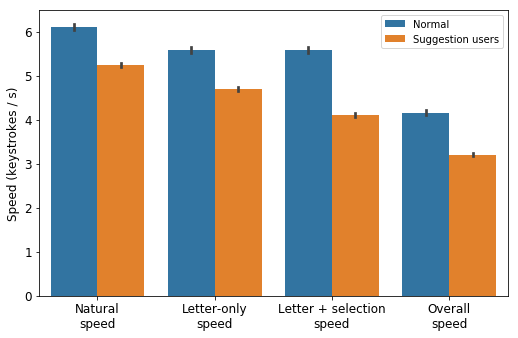

In [520]:
f,ax = plt.subplots(1,1,figsize=(7,4.5))

data = participants.copy()
data.loc[data.n_predict < 1,'user_type'] = 'Normal'
data.loc[data.n_predict > 5,'user_type'] = 'Suggestion users'
data = data.loc[data.user_type.notna()]
data = data.loc[data.iki_natural.notna()]

data.iki_natural = data.iki_natural.apply(np.reciprocal)*1000
data.iki_overall = data.iki_overall.apply(np.reciprocal)*1000
data.iki_letters = data.iki_letters.apply(np.reciprocal)*1000
data.iki_letters_and_ite = data.iki_letters_and_ite.apply(np.reciprocal)*1000

data = data.sort_values('user_type')

data_melt = pd.melt(data[['user_type','iki_natural','iki_letters','iki_letters_and_ite','iki_overall']],id_vars='user_type')

sns.barplot('variable','value',hue='user_type',data=data_melt,ax=ax)

ax.set_xlabel('')
ax.set_xticklabels(['Natural\nspeed', 'Letter-only\nspeed','Letter + selection\nspeed','Overall\nspeed'])
ax.set_ylabel('Speed (keystrokes / s)')
ax.legend(title='User type')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax.legend(title='')

f.tight_layout(pad=0)

f.savefig('./figures/bar_typing_speeds.png', dpi=300)

In [231]:
res = data[[
    'user_type',
    'iki_natural',
    'iki_letters',
    'iki_letters_and_ite',
    'iki_overall'
]].groupby('user_type').mean().round(2)
disp.loc['Normal users'] = res.loc['Normal'].apply(str).values
disp.loc['Suggestion users'] = res.loc['Suggestion users'].apply(str).values


disp.loc['Normal users'] += '\n('
disp.loc['Suggestion users'] += '\n('

res = data[[
    'user_type',
    'iki_natural',
    'iki_letters',
    'iki_letters_and_ite',
    'iki_overall'
]].groupby('user_type').std().round(2)
disp.loc['Normal users'] += res.loc['Normal'].apply(str).values
disp.loc['Suggestion users'] += res.loc['Suggestion users'].apply(str).values


disp.loc['Normal users'] += ')'
disp.loc['Suggestion users'] += ')'

from IPython.display import display

# Assuming the variable df contains the relevant DataFrame
display(disp.style.set_properties(**{
    'white-space': 'pre-wrap',
}))

,Natural speed,Letter-only speed,Letter-and-selection speed,Overall speed
Normal users,6.1 (1.81),5.58 (1.69),5.58 (1.68),4.16 (1.47)
Suggestion users,5.24 (1.43),4.69 (1.28),4.1 (1.21),3.2 (0.86)
Difference (controlled for natural speed),nan,nan,nan,nan


In [200]:
data = participants.dropna(subset=['user_type']).copy()
data['user_bool'] = data.user_type.map({'Normal': 0, 'Suggestion users': 1})
data.rate_predict = data.rate_predict.apply(np.reciprocal)
data.iki_natural = data.iki_natural.apply(np.reciprocal) * 1000

for i in ['natural','letters','letters_and_ite','overall']:
    data = data.dropna(subset=['iki_'+i,'rate_predict'])
    data['speed'] = data['iki_'+i].apply(np.reciprocal) * 1000
    X = data[['user_bool','iki_natural']]
#     X = preprocessing.StandardScaler().fit_transform(X)
    X = sm.add_constant(X)

    y = data[['speed']]
#     y = preprocessing.StandardScaler().fit_transform(y)
    model = sm.OLS(y,X)
    results = model.fit()
    print()
    print(i)
    print('mag: ',results.params[1])
    print('std: ', results.bse[1])
    print('p: ', results.pvalues[1])
    print('r2: ',results.rsquared)


natural
mag:  -10.711798516441476
std:  1.168317209230711
p:  6.901303447259703e-20
r2:  0.7621945229389308

letters
mag:  -0.12060347401245934
std:  0.009619270727774189
p:  1.6183670359803845e-35
r2:  0.9559712667262096

letters_and_ite
mag:  -0.7441018819986868
std:  0.01256636358592292
p:  0.0
r2:  0.9317025258803037

overall
mag:  -0.4257351710686976
std:  0.018818697398426103
p:  7.162634141862387e-108
r2:  0.7527290172208425


#### How does the extent of suggestion usage affect typing speed?

0.04646970146693849 0.001969829708726918 8.267984868482603e-114 0.38046965066678506


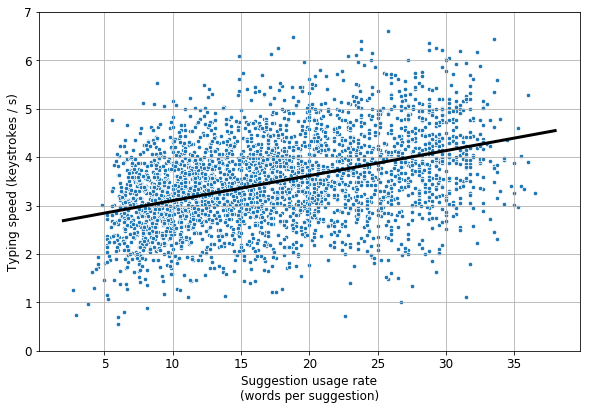

In [521]:
f,ax = plt.subplots(1,1,figsize=(8,5.5))

data = participants.loc[(participants.n_predict > 3) & (participants.n_predict < 20)].copy()
data['speed_overall'] = data.iki_overall.apply(np.reciprocal) * 1000
data.rate_predict = data.rate_predict.apply(np.reciprocal)
sns.scatterplot('rate_predict','speed_overall',data=data,ax=ax,color='C0',s=20)

slope,intercept, r, p, std = stats.linregress(data.rate_predict,data.speed_overall)
print(slope,std,p,r)
sns.lineplot([2,38],[intercept,slope*40 + intercept],color='k',lw=3)

ax.set_ylim((0,7))

ax.set_xlabel('Suggestion usage rate\n(words per suggestion)')
ax.set_ylabel('Typing speed (keystrokes / s)')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax.grid()

f.tight_layout(pad=0)

f.savefig('./figures/regression_speed.png',dpi=300)

In [153]:
data = participants.loc[(participants.n_predict > 5) & (participants.n_predict < 20)].copy()
data.rate_predict = data.rate_predict.apply(np.reciprocal)
data.iki_natural = data.iki_natural.apply(np.reciprocal) * 1000

for i in ['natural','letters','letters_and_ite','overall']:
    data = data.dropna(subset=['iki_'+i,'rate_predict'])
    data['speed'] = data['iki_'+i].apply(np.reciprocal) * 1000
    X = data[['rate_predict','iki_natural']]
#     X = preprocessing.StandardScaler().fit_transform(X)
    X = sm.add_constant(X)

    y = data[['speed']]
#     y = preprocessing.StandardScaler().fit_transform(y)
    model = sm.OLS(y,X)
    results = model.fit()
    print()
    print(i)
    print('slope: ',results.params[1])
    print('std: ', results.bse[1])
    print('p: ', results.pvalues[1])
    print('r2: ',results.rsquared)


natural
slope:  -0.42163057839662144
std:  0.15006907903443303
p:  0.0050043251903535355
r2:  0.7918167672449055

letters
slope:  0.00619529374648684
std:  0.0016482878637035438
p:  0.00017528014312778744
r2:  0.9232968186447421

letters_and_ite
slope:  0.051029736401971976
std:  0.00177246164497224
p:  4.633200638627602e-155
r2:  0.8896801469064919

overall
slope:  0.026604684021358564
std:  0.0026308872717510576
p:  1.5680824689796768e-23
r2:  0.5975940416923233


#### How does the extent of usage affect KPC?

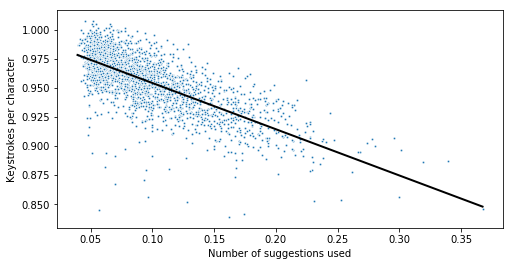

In [510]:
f,ax = plt.subplots(1,1,figsize=(8,4))
mask = (participants.n_predict > 5) & (participants.n_predict < 26)
ax = sns.scatterplot(participants.loc[mask].rate_predict, participants.loc[mask].KPC, color='C0',s=7)

X = participants.loc[mask].rate_predict
xmin = X.min()
xmax = X.max()

X = sm.add_constant(X)
y = participants.loc[mask].KPC
model = sm.OLS(y,X)
results = model.fit()
intercept, slope = results.params[0], results.params[1]

sns.lineplot([xmin,xmax],[slope*xmin + intercept,slope*xmax + intercept],color='k',lw=2)

ax.set_xlabel('Number of suggestions used')
ax.set_ylabel('Keystrokes per character')

f.savefig('./figures/regression_kpc.png',dpi=300)

In [379]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    KPC   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     2711.
Date:                Wed, 28 Aug 2019   Prob (F-statistic):               0.00
Time:                        19:10:46   Log-Likelihood:                 6405.6
No. Observations:                2396   AIC:                        -1.281e+04
Df Residuals:                    2394   BIC:                        -1.280e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.9940      0.001   1238.417      0.000       0.992       0.996
rate_predict    -0.3976      0.008    -52.069      0.000      -0.413      -0.383
==============================================================================
Omnibus:                      530.202   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2355.493
Skew:                          -0.998   Prob(JB):                         0.00
Kurtosis:                       7.429   Cond. No.                         22.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Time series analysis

In [128]:
data = log[['participant_id','ts_id','entry_id','iki','key','ite']].copy()

# First iki of each word is undefined
data.loc[data.groupby(['ts_id','entry_id']).head(1).index, 'iki'] = np.nan

# Create artificial timestamp based on the iki
data['iki_rel'] = data.iki / data.participant_id.map(participants.iki_natural)
data['timestamp'] = data.groupby(['ts_id','entry_id']).iki.cumsum()
data['timestamp_rel'] = data.groupby(['ts_id','entry_id']).iki_rel.cumsum()
data.loc[data.groupby(['ts_id','entry_id']).head(1).index, 'timestamp'] = 0
data.loc[data.groupby(['ts_id','entry_id']).head(1).index, 'timestamp_rel'] = 0

# Some processing requires indexing based on ts and entry id's
data.set_index(['ts_id','entry_id'], inplace=True)
data = data.drop(data.loc[~data.key.str.contains('[a-zA-Z]')].index) # Remove entries with backspace, punctuation, numbers
data['ite'] = words.set_index(['ts_id','entry_id']).ite
data['ite2'] = words.set_index(['ts_id','entry_id']).ite2
data['word'] = words.set_index(['ts_id','entry_id']).word
data['word_length'] = words.set_index(['ts_id','entry_id']).word_length
data.reset_index(inplace=True)

# Label each action within an entry
data['action_id'] = data.groupby(['ts_id','entry_id']).cumcount()

# Count the number of actions per entry
data.set_index(['ts_id','entry_id'], inplace=True)
data['n_actions'] = data.groupby(['ts_id','entry_id']).size()
data.reset_index(inplace=True)

In [370]:
words.loc[words.ite2 == 'completion'].word.value_counts().head(10)

tomorrow       164
Thursday       102
expected        90
information     90
questions       79
September       74
against         63
probably        61
available       56
anything        55
Name: word, dtype: int64

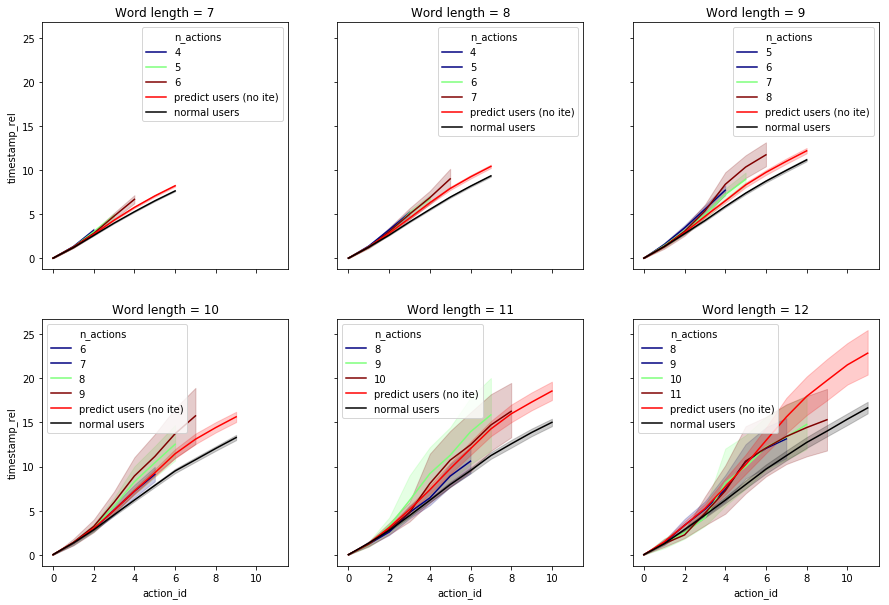

In [131]:
f,ax = plt.subplots(2,3,figsize=(15,10), sharex=True, sharey=True)
ax=ax.flatten()

tmp = data.loc[data.ite != 'autocorr'].copy()
tmp.ite2 = tmp.ite2.fillna('none')
tmp = tmp.loc[tmp.ite2.isin(['none','completion', 'correction'])]
mask = tmp.key.str.len() == 1
tmp = tmp.loc[mask]
for i in range(7,13):
    tmp2 = tmp.loc[tmp.word_length == i].copy()
    mask = ((tmp2.n_actions.isin(range(max(3,i-3),i))) & (tmp2.ite2 == 'completion'))
    mask |= ((tmp2.n_actions == i) & (tmp2.ite2 == 'none'))
    tmp2 = tmp2.loc[mask]
    
    tmp2 = tmp2.groupby(['ite2','n_actions','action_id']).filter(lambda x: x.shape[0] > 5)
    
    predict_users = tmp2.loc[tmp2.participant_id.map(participants.n_predict) > 5]
    normal_users = tmp2.loc[tmp2.participant_id.map(participants.n_predict)  < 4]
    sns.lineplot(
        'action_id',
        'timestamp_rel',
        data=predict_users.loc[predict_users.ite2 == 'completion'],
        hue='n_actions',
        palette='jet',
        ax=ax[i-7]
    )
    sns.lineplot(
        'action_id',
        'timestamp_rel',
        data=predict_users.loc[predict_users.ite == 'none'],
        ax=ax[i-7],
        color='r',
        label='predict users (no ite)'
    )
    sns.lineplot(
        'action_id',
        'timestamp_rel',
        data=normal_users.loc[normal_users.ite == 'none'],
        ax=ax[i-7],
        color='k',
        label='normal users'
    )
    ax[i-7].set_title('Word length = {}'.format(i))

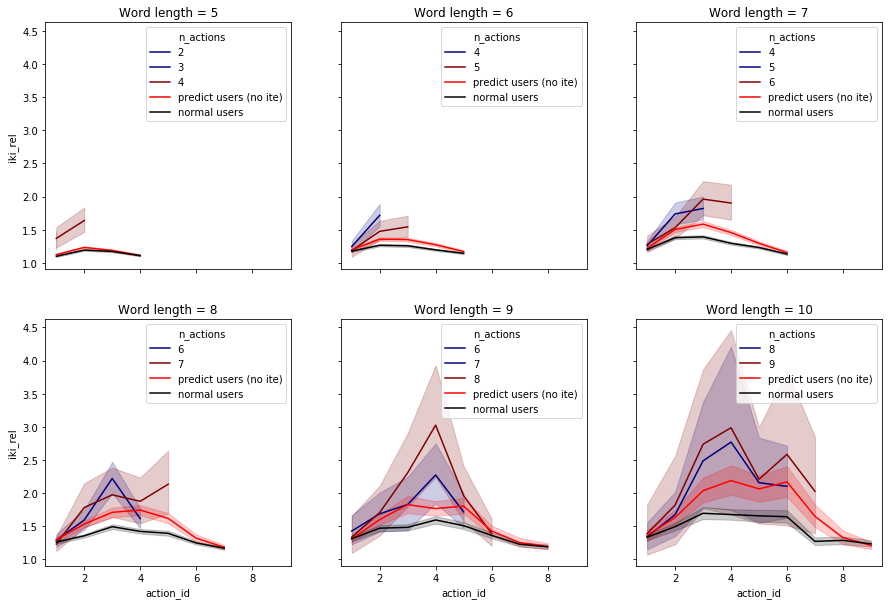

In [221]:
f,ax = plt.subplots(2,3,figsize=(15,10), sharex=True, sharey=True)
ax=ax.flatten()

tmp = data.loc[data.ite != 'autocorr'].copy()
tmp.ite2 = tmp.ite2.fillna('none')
tmp = tmp.loc[tmp.ite2.isin(['none','completion'])]
mask = tmp.key.str.len() == 1
tmp = tmp.loc[mask]
for i in range(5,11):
    tmp2 = tmp.loc[tmp.word_length == i].copy()
    mask = ((tmp2.n_actions.isin(range(max(3,i-2),i))) & (tmp2.ite2 == 'completion'))
    mask |= ((tmp2.n_actions == i) & (tmp2.ite2 == 'none'))
    tmp2 = tmp2.loc[mask]
    
    tmp2 = tmp2.groupby(['ite2','n_actions','action_id']).filter(lambda x: x.shape[0] > 5)
    
    predict_users = tmp2.loc[tmp2.participant_id.map(participants.n_predict) > 5]
    normal_users = tmp2.loc[tmp2.participant_id.map(participants.n_predict)  < 4]
    sns.lineplot(
        'action_id',
        'iki_rel',
        data=predict_users.loc[predict_users.ite2 == 'completion'],
        hue='n_actions',
        palette='jet',
        ax=ax[i-5]
    )
    sns.lineplot(
        'action_id',
        'iki_rel',
        data=predict_users.loc[predict_users.ite2 == 'none'],
        ax=ax[i-5],
        color='r',
        label='predict users (no ite)'
    )
    sns.lineplot(
        'action_id',
        'iki_rel',
        data=normal_users.loc[normal_users.ite2 == 'none'],
        ax=ax[i-5],
        color='k',
        label='normal users'
    )
    ax[i-5].set_title('Word length = {}'.format(i))

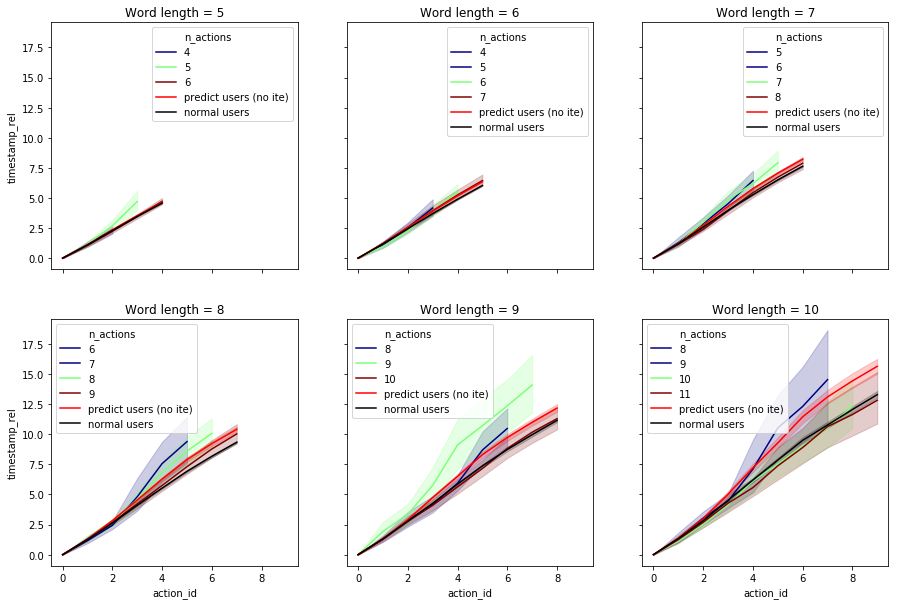

In [225]:
f,ax = plt.subplots(2,3,figsize=(15,10), sharex=True, sharey=True)
ax=ax.flatten()

tmp = data.loc[data.ite != 'autocorr'].copy()
tmp.ite2 = tmp.ite2.fillna('none')
tmp = tmp.loc[tmp.ite2.isin(['none','correction'])]
mask = tmp.key.str.len() == 1
tmp = tmp.loc[mask]
for i in range(5,11):
    tmp2 = tmp.loc[tmp.word_length == i].copy()
    mask = ((tmp2.n_actions.isin(range(max(3,i-1),i+2))) & (tmp2.ite2 == 'correction'))
    mask |= ((tmp2.n_actions == i) & (tmp2.ite2 == 'none'))
    tmp2 = tmp2.loc[mask]
    
    tmp2 = tmp2.groupby(['ite2','n_actions','action_id']).filter(lambda x: x.shape[0] > 5)
    
    predict_users = tmp2.loc[tmp2.participant_id.map(participants.n_predict) > 5]
    normal_users = tmp2.loc[tmp2.participant_id.map(participants.n_predict)  < 4]
    sns.lineplot(
        'action_id',
        'timestamp_rel',
        data=predict_users.loc[predict_users.ite2 == 'correction'],
        hue='n_actions',
        palette='jet',
        ax=ax[i-5]
    )
    sns.lineplot(
        'action_id',
        'timestamp_rel',
        data=predict_users.loc[predict_users.ite2 == 'none'],
        ax=ax[i-5],
        color='r',
        label='predict users (no ite)'
    )
    sns.lineplot(
        'action_id',
        'timestamp_rel',
        data=normal_users.loc[normal_users.ite2 == 'none'],
        ax=ax[i-5],
        color='k',
        label='normal users'
    )
    ax[i-5].set_title('Word length = {}'.format(i))

## Are certain strategies used for certain words more than for others?

#### Model preparation

In [401]:
qwerty = [
    'qwertyuiop',
    'asdfghjkl',
    'zxcvbnm'
]
tmp = qwerty
for i,line in enumerate(tmp):
    qwerty[i] = list(line)
    
tmp = qwerty
qwerty = {}
# Invert so we have indices
for i,line in enumerate(tmp):
    for j,char in enumerate(line):
        qwerty[char] = [i,j]
qwerty = pd.DataFrame(qwerty).T
# Offset the rows
qwerty.loc[qwerty[0] == 1, 1] += 0.5
qwerty.loc[qwerty[0] == 2, 1] += 1.5

qwerty_dist = spatial.distance_matrix(qwerty,qwerty,p=1)
qwerty_dist = pd.DataFrame(qwerty_dist,index=qwerty.index,columns=qwerty.index)

# Flatten
tmp = qwerty_dist.copy()
qwerty_dist = {}
for i in tmp.index:
    for j in tmp.columns:
        qwerty_dist[i+j] = tmp.loc[i,j]

def get_distance(x):
    d = 0
    for i,c in enumerate(x[1:]):
        d += qwerty_dist[x[i:i+2]]
    return d

In [402]:
offset_keys = pd.read_csv('./data/key_offset.csv',index_col=0)
def get_offset(x):
    effort = 0
    for c in x:
        if c in offset_keys.index:
            effort += offset_keys.loc[c,'offset_one_thumb']
    return effort

In [403]:
mask = words.ite.isin(['none','predict'])
mask &= words.word_length > 1
mask &= words.word_length < 14
mask &= (words.word == words.ite_input) | (words.ite == 'none') # Only words which are the same as the input
data = words.loc[mask,['word','word_length','freq','ite2','iki','type','ite_input_prev']].copy()
# Add features
data['leadup_length'] = data.word_length
data.loc[data.ite2.notna(),'leadup_length'] = data.ite_input_prev.str.len()
data['is_contraction'] = (data.type == 'contraction').astype(float)
data['is_capitalized'] = (data.type == 'proper').astype(float)
data.drop('type',axis=1,inplace=True)
data.drop('ite_input_prev',axis=1,inplace=True)

# Remove the less common substrategies
data.ite2 = data.ite2.fillna('none')
data = data.loc[data.ite2.isin(['completion','correction','contraction','capitalization','prediction','none'])]

# Add features that are based on the normally typed instances of the word
data2 = words.loc[words.ite == 'none'].groupby('word').filter(lambda x: x.shape[0] > 20)
data['base_speed'] = data.word.map(data2.groupby('word').iki_letters.mean()) # Use letter-only speed
data['touch_offset'] = data.word.map(get_offset) / data.word_length
data['backspaces'] = data.word.map(data2.groupby('word').n_backspace.mean())

# Drop any nan
data = data.dropna()

# Transform to get better distributions
data.freq = np.log10(data.freq)
data.iki = data.iki.apply(np.reciprocal)*1000
data = data.rename(columns={'iki':'leadup_speed'})
data.base_speed = data.base_speed.apply(np.reciprocal)*1000

# Remove outliers
data = data.loc[data.touch_offset < 1].copy()
data = data.loc[data.leadup_speed < 20].copy()

# Set word index
data = data.set_index('word')

In [404]:
data.ite2.value_counts()

none              740069
completion         19599
correction          9190
prediction          1494
contraction          647
capitalization       528
Name: ite2, dtype: int64

/Users/itto/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/itto/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/itto/miniconda3/lib/python3.6/site-packages/statsmodels/nonparametric/bandwidths.py:20: RuntimeWarning: invalid value encountered in minimum
  return np.minimum(np.std(X, axis=0, ddof=1), IQR)
/Users/itto/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


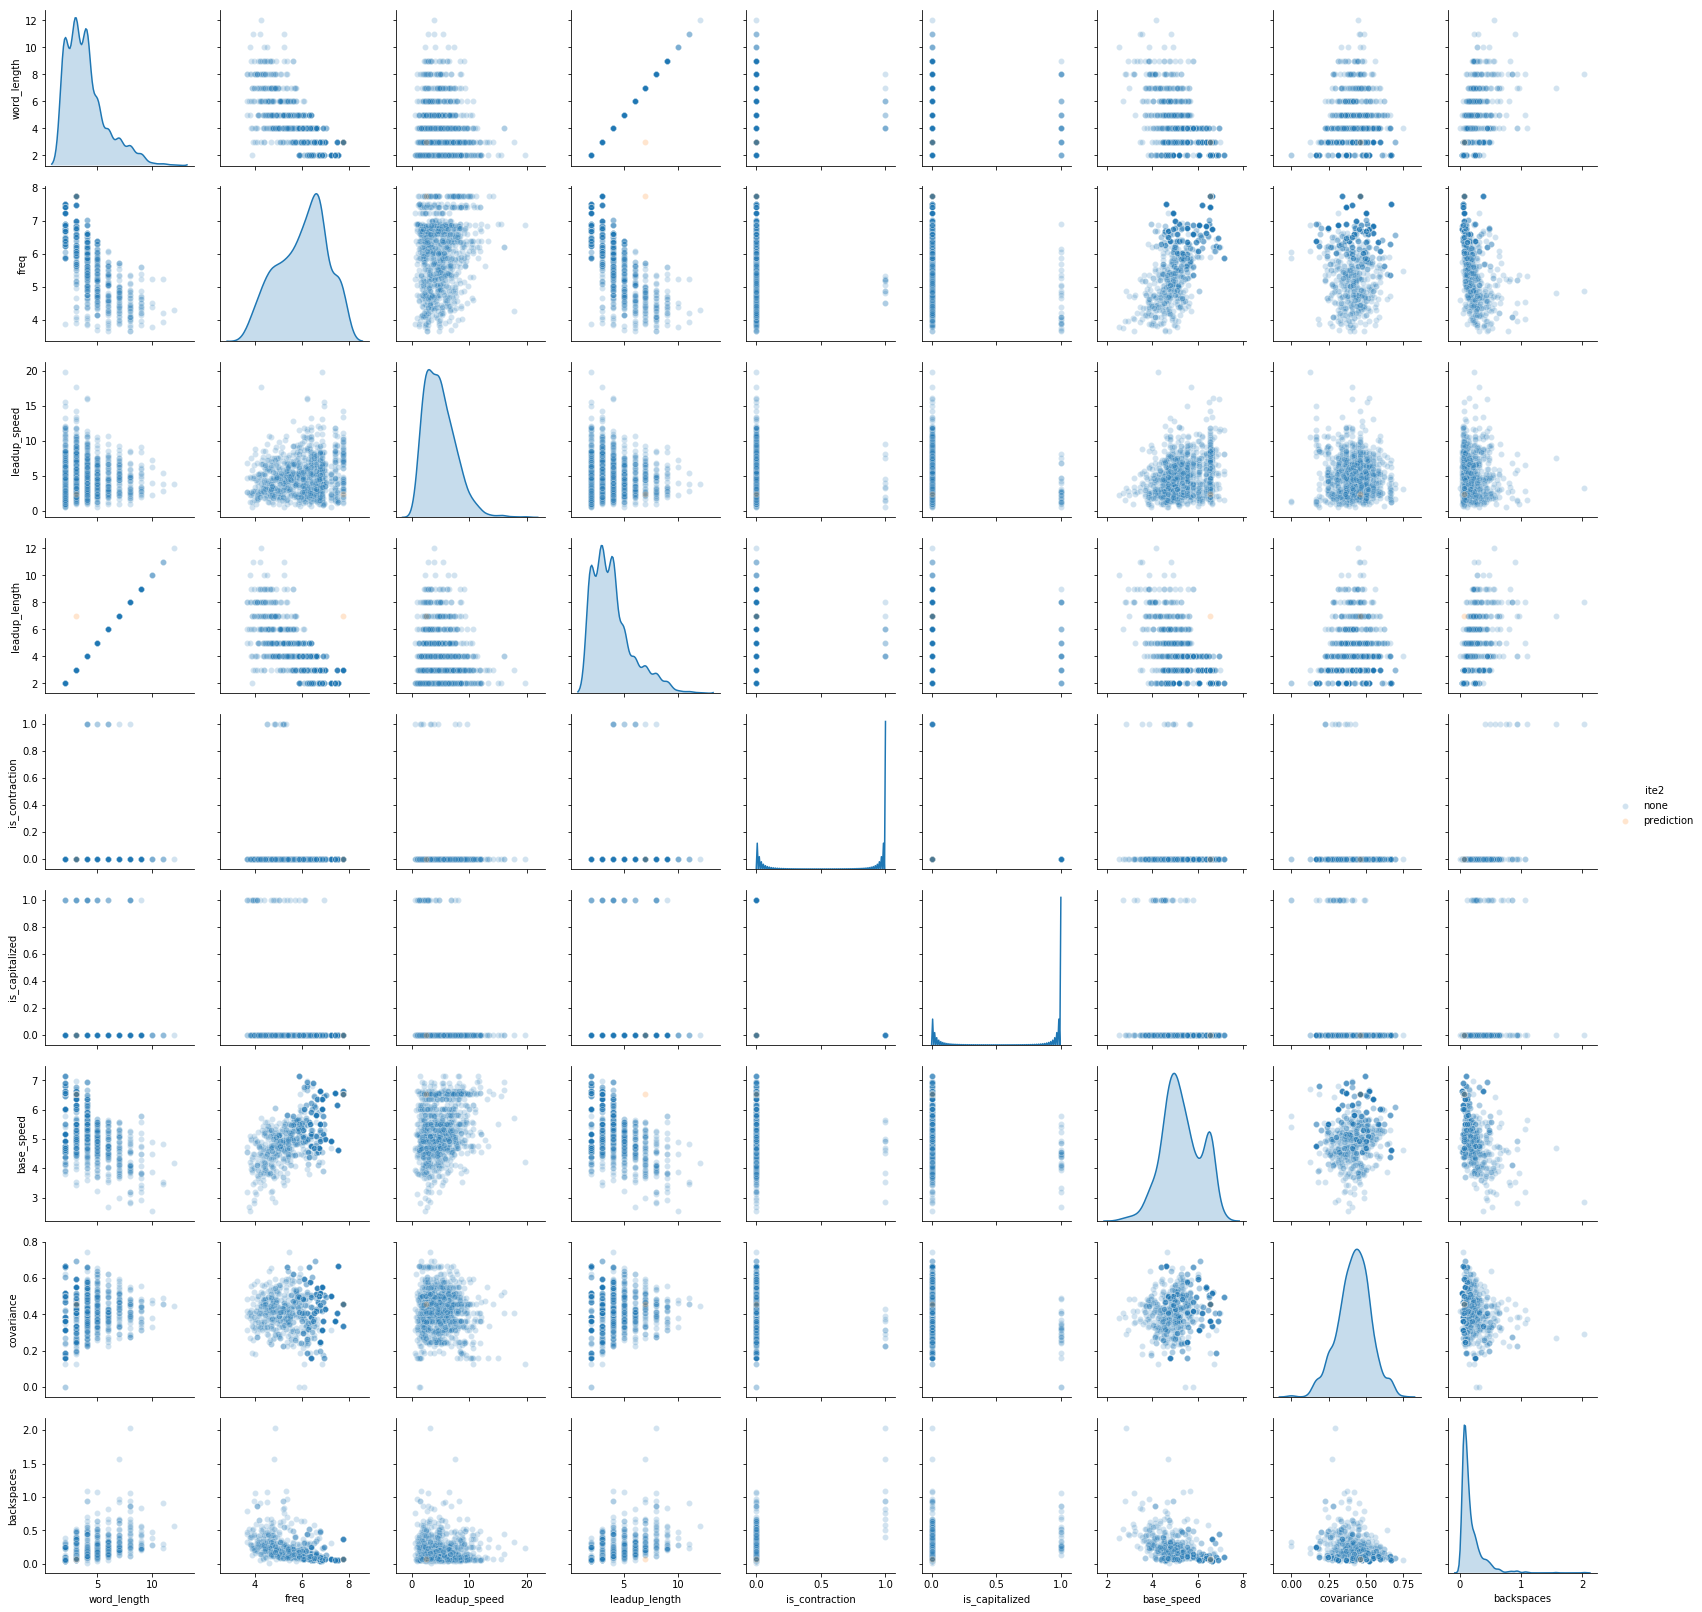

In [634]:
mask = (data.ite2.isin(['prediction','none']))
sns.pairplot(data.loc[mask].sample(1000),hue='ite2',plot_kws={'alpha':0.2})

In [409]:
# Preprocess X
X = data.loc[:,data.columns != 'ite2'].copy()
X.word_length = X.word_length.astype(float)
X_scaled = preprocessing.StandardScaler().fit_transform(X)
X = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X.is_contraction = data.is_contraction
X.is_capitalized = data.is_capitalized

# Preprocess y
y = data['ite2'].copy()

# Split data
X_train,X_test,y_train,y_test=model_selection.train_test_split(X,y,test_size=0.1,random_state=1)

In [410]:
X_train.shape

(694374, 9)

#### Coefficients

In [266]:
# Fit sklearn
reg = linear_model.LogisticRegression(solver='lbfgs',multi_class='ovr',max_iter=1000,fit_intercept=True,C=np.inf)
reg.fit(X_train,y_train)
reg_disp = pd.DataFrame(reg.coef_,index=reg.classes_,columns=X.columns).T.loc[['word_length','freq','is_contraction','is_capitalized','base_speed','covariance','backspaces','leadup_speed','leadup_length']]

reg_disp

,capitalization,completion,contraction,correction,none,prediction
word_length,-1.050594,5.530571,0.628132,0.766715,-6.183731,-2.068563
freq,-0.573267,-0.405618,-0.121544,-0.384957,0.229347,0.517628
is_contraction,-11.130005,0.325631,10.478220,-0.841254,-0.822834,0.888107
is_capitalized,5.708264,-0.247228,-1.338169,-0.545177,-0.353250,0.066683
base_speed,0.467733,0.037605,-0.154312,0.132571,-0.171885,0.326209
covariance,0.135019,0.052765,0.135279,-0.042286,0.031530,-0.126346
backspaces,-0.023593,-0.194974,-0.111414,-0.100596,0.149853,-0.485114
leadup_speed,-1.661353,-3.405384,0.132532,-1.979919,2.158436,-1.100120
leadup_length,1.434398,-5.433730,-1.295959,-0.286113,5.409937,2.653278


In [500]:
def to_asterix(x):
    if x <= 0.01:
        return '***'
    elif x <= 0.05:
        return '**'
    elif x <= 0.1:
        return '*'
    else:
        return ''

params = []
params_disp = []
X_train = sm.add_constant(X_train)
for i in y_train.sort_values().unique():
    c = X_train.columns
    if i == 'none':
        continue # Remove this line to see the "none" column
        model = sm.Logit((y_train != i).astype(float),X_train)
        i = 'no suggestion'
    if i == 'prediction':
        c = ['const','word_length','freq','is_contraction','is_capitalized','base_speed','touch_offset','backspaces']
    if i in ['capitalization','contraction']:
        c = ['const','word_length','freq','is_contraction','is_capitalized','base_speed','touch_offset','backspaces','leadup_speed']
    model = sm.Logit((y_train == i).astype(float),X_train.loc[:,c])
    results = model.fit(method='lbfgs',maxiter=1000)
    a = results.params
    for param,val in results.params.iteritems():
        a.loc[param] = '{}{}\n({})'.format(
            str(round(val,2)),
            to_asterix(results.pvalues.loc[param]),
            str(round(results.bse.loc[param],2))
        )
    params.append(results.params.to_frame(i))
    params_disp.append(a.to_frame(i))
params_disp = pd.concat(params_disp,axis=1,sort=False)
params = pd.concat(params,axis=1,sort=False)
params_disp = params_disp.fillna('N/A')
params_disp = params_disp.loc[['const','word_length','freq','is_contraction','is_capitalized','base_speed','touch_offset','backspaces','leadup_speed','leadup_length']]

In [501]:
from IPython.display import display

# Assuming the variable df contains the relevant DataFrame
display(params_disp.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap',
}))

,capitalization,completion,contraction,correction,prediction
const,-11.36*** (0.24),-8.35*** (0.07),-12.55*** (0.61),-5.84*** (0.03),-6.48*** (0.04)
word_length,0.37*** (0.05),5.53*** (0.04),-0.22* (0.13),0.77*** (0.02),0.55*** (0.05)
freq,-0.62*** (0.09),-0.4*** (0.03),0.2 (0.14),-0.38*** (0.02),0.56*** (0.05)
is_contraction,-0.67 (1.72),0.32*** (0.12),11.52*** (0.66),-0.84*** (0.12),0.31 (1.05)
is_capitalized,5.61*** (0.24),-0.25*** (0.09),-1.36 (10.58),-0.55*** (0.06),0.66*** (0.25)
base_speed,0.45*** (0.07),0.04 (0.02),-0.22*** (0.08),0.13*** (0.02),0.15*** (0.04)
touch_offset,0.15*** (0.05),0.05*** (0.02),0.07 (0.07),-0.04*** (0.01),-0.1*** (0.03)
backspaces,-0.02 (0.04),-0.19*** (0.02),-0.17*** (0.03),-0.1*** (0.01),-0.58*** (0.07)
leadup_speed,-1.7*** (0.12),-3.4*** (0.05),0.19** (0.08),-1.98*** (0.02),N/A
leadup_length,N/A,-5.43*** (0.04),N/A,-0.29*** (0.01),N/A


#### What is the performance for classifying the sub-strategy?

In [290]:
def predict_prob(params, x):
    odds = (params * x).sum(axis=1).apply(np.exp)
    return odds/(1+odds)    

In [778]:
y_prob = pd.DataFrame(columns=params.columns)
x = sm.add_constant(X_test)
for c in params.columns:
    y_prob[c] = predict_prob(params[c],x)
y_pred = y_prob.idxmax(axis=1)

# Keep only instances where suggestion was used
y_pred = y_pred.loc[y_test != 'none']
y_test_red = y_test.loc[y_test != 'none']

confusion_matrix = pd.DataFrame(metrics.confusion_matrix(y_test_red,y_pred), index=y_pred.sort_values().unique(),columns=y_pred.sort_values().unique())
confusion_matrix

,capitalization,completion,contraction,correction,prediction
capitalization,13,0,0,53,0
completion,3,1849,12,86,6
contraction,0,0,59,0,0
correction,8,191,12,706,12
prediction,1,31,0,96,8


In [762]:
metrics.accuracy_score(y_test_red,y_pred)

0.8519973804846104

In [763]:
y_test_red.shape

(3054,)

#### What is the performance for estimating the probability of selection?

In [421]:
def predict_prob(params, x):
    odds = (params * x).sum(axis=1).apply(np.exp)
    return odds/(1+odds)    

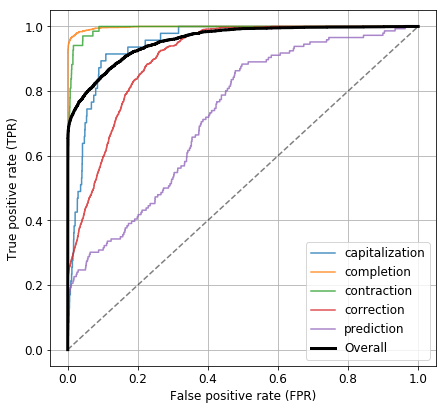

In [562]:
f,ax = plt.subplots(1,1,figsize=(6,5.5))

for i in params.columns:
    if i == 'none':
        continue
    
    mask = (y_test == i) | (y_test == 'none')
    X_test_s = X_test.loc[mask]
    y_test_s = y_test.loc[mask] != 'none'
   
    y_prob = pd.DataFrame(columns=params.columns)
    x = sm.add_constant(X_test_s)
    for c in params.columns:
        y_prob[c] = predict_prob(params[c],x)
    y_pred = y_prob.sum(axis=1)

    fpr, tpr, thresh = metrics.roc_curve(y_test_s, y_pred) 
    
    ax.plot(fpr,tpr, label = i,alpha=0.8)
    
y_prob = pd.DataFrame(columns=params.columns)
x = sm.add_constant(X_test)
for c in params.columns:
    y_prob[c] = predict_prob(params[c],x)
y_pred = y_prob.sum(axis=1)

y_test_bool = y_test != 'none'

fpr, tpr, thresh = metrics.roc_curve(y_test_bool, y_pred)

ax.plot(fpr,tpr,label='Overall',lw=3,c='k')
ax.plot([0,1],[0,1],'--',c='k',alpha=0.5)

ax.legend(fontsize=12)
ax.grid()

ax.set_xlabel('False positive rate (FPR)')
ax.set_ylabel('True positive rate (TPR)')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

f.tight_layout(pad = 0)

f.savefig('./figures/roc_selection.png',dpi=300)

In [428]:
roc = pd.DataFrame([fpr,tpr,thresh]).T
roc.columns = ['fpr','tpr','thresh']
roc = roc.set_index('thresh')
roc.loc[(roc.fpr < 0.1) & (roc.tpr > 0.8)].sample(5)

,fpr,tpr
thresh,,
0.055081,0.060230,0.803536
0.042392,0.090042,0.836935
0.054821,0.060703,0.804519
0.044859,0.083092,0.829404
0.056326,0.057869,0.800262


In [429]:
confusion_matrix = pd.DataFrame(metrics.confusion_matrix(y_test_bool,y_pred > 0.05))
confusion_matrix

,0,1
0,68861,5238
1,569,2485


In [430]:
metrics.accuracy_score(y_test_bool,y_pred > 0.05)

0.9247339701631823

In [431]:
metrics.precision_score(y_test_bool,y_pred > 0.05)

0.32176615304933315

In [432]:
metrics.recall_score(y_test_bool,y_pred > 0.05)

0.8136869679109365

In [439]:
y_test.loc[y_test_bool != (y_pred > 0.05)].value_counts() / y_test.value_counts()

capitalization    0.234043
completion        0.008290
contraction       0.029412
correction        0.507532
none              0.070689
prediction        0.698630
Name: ite2, dtype: float64

In [698]:
y_test.shape

(84156,)

#### Example of how word length affects the strategy used

In [684]:
words.loc[(words.word_length < 6) & (words.ite2 != 'none')].ite2.value_counts(normalize=True)

correction        0.398561
completion        0.356575
prediction        0.100915
contraction       0.057805
other             0.038162
capitalization    0.034338
add_space         0.009897
no_change         0.001949
fixup             0.001799
Name: ite2, dtype: float64

In [685]:
words.loc[(words.word_length >= 6) & (words.ite2 != 'none')].ite2.value_counts(normalize=True)

completion        0.705443
correction        0.238203
capitalization    0.020570
contraction       0.012348
other             0.008883
prediction        0.008789
fixup             0.004190
add_space         0.001229
no_change         0.000347
Name: ite2, dtype: float64

## Do certain participants use prediction more than others?

In [528]:
data = words.groupby('ite').participant_id.value_counts(normalize=True, ascending=True).reset_index(1, drop=True)
data = data.groupby(data.index).cumsum()
data = data.reset_index()
data = data.reset_index()
data = data.rename(columns={'index':'participants','participant_id':'cumulative_share'})
data.participants = data.groupby('ite').participants.apply(lambda x: (x - x.min())/(x.max() - x.min()))

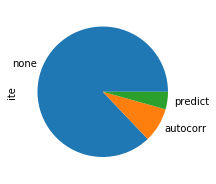

In [538]:
f,ax = plt.subplots(1,1,figsize=(3,3))

words.ite.value_counts(normalize=True).plot.pie(ax=ax)

ax.set_aspect('equal')

f.savefig('./figures/pie_ite_usage.png', dpi=300)

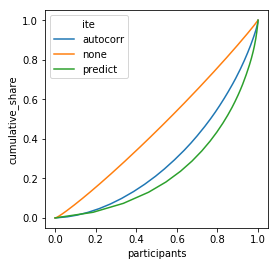

In [537]:
f,ax = plt.subplots(1,1,figsize=(4,4))
sns.lineplot(data.participants, data.cumulative_share, hue = data.ite, ax=ax)

f.savefig('./figures/lorenz_ite_usage.png', dpi=300)

In [540]:
data = words.groupby('ite2').participant_id.value_counts(normalize=True, ascending=True).reset_index(1, drop=True)
data = data.groupby(data.index).cumsum()
data = data.reset_index()
data = data.reset_index()
data = data.rename(columns={'index':'participants','participant_id':'cumulative_share'})
data.participants = data.groupby('ite2').participants.apply(lambda x: (x - x.min())/(x.max() - x.min()))

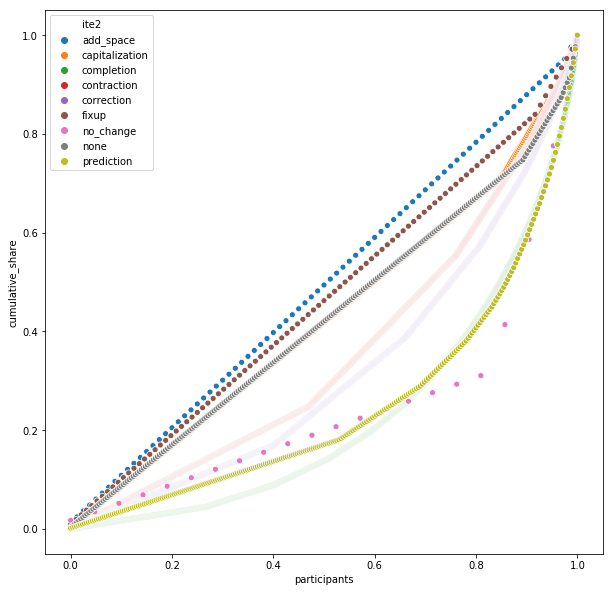

In [541]:
f,ax = plt.subplots(1,1,figsize=(10,10))
sns.scatterplot(data.participants, data.cumulative_share,hue=data.ite2, ax=ax)

In [58]:
data = participants_.loc[
    participants.n_predict > 2,
    ['AGE','GENDER','TIME_SPENT_TYPING','TYPE_ENGLISH','hands1','hands2']
].copy()
data = data.loc[data.AGE < 56].copy()

data['predict'] = participants_ite.predict
data.predict = stats.boxcox(data.predict)[0]

data['completion'] = participants_ite2.completion
data['correction'] = participants_ite2.correction

# Characters per second based on words where no ITE was used
data['natural_speed'] = words.loc[(words.ite == 'none') & (words.word_length < 5)].groupby('participant_id').iki_natural.mean()
data.natural_speed = np.reciprocal(data.natural_speed) * 1000

data['age_binned'] = pd.cut(data.AGE,[0,10,15,19,25,35,55])

data['experience_binned'] = pd.cut(data.TIME_SPENT_TYPING,6)

data['native_english'] = participants_.NATIVE_LANGUAGE == 'en'

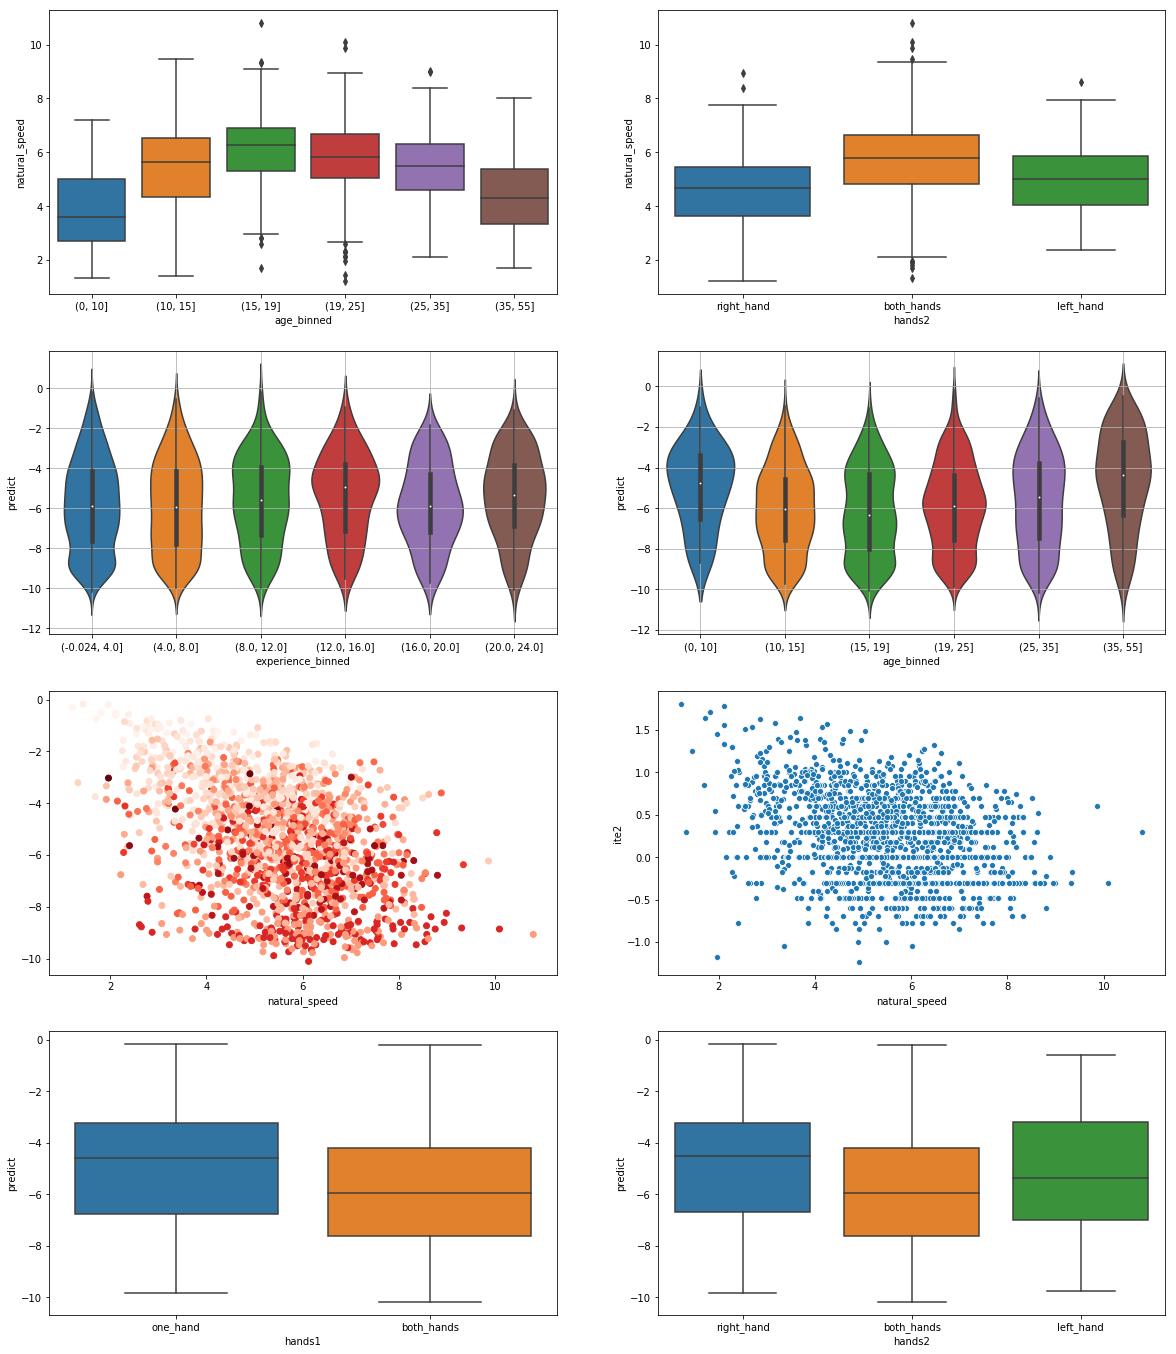

In [59]:
f,ax = plt.subplots(4,2,figsize=(20,24))
ax = ax.flatten()

sns.boxplot(data.age_binned, data.natural_speed,ax=ax[0])

sns.boxplot(data.hands2, data.natural_speed, ax=ax[1])

sns.violinplot(data.experience_binned, data.predict, ax=ax[2])
ax[2].grid()

sns.violinplot(data.age_binned, data.predict, ax=ax[3])
ax[3].grid()

data2 = data.loc[(data.completion > 0) & (data.correction > 0)].copy()
im = ax[4].scatter(data2.natural_speed, data2.predict, c=data2.correction, cmap='Reds')
ax[4].set_xlabel('natural_speed')
# f.colorbar(im,ax=ax[4])

data2 = data.loc[(data.completion > 0) & (data.correction > 0)].copy()
data2['ite2'] = np.log10(data2.completion/data2.correction)
sns.scatterplot(data2.natural_speed, data2.ite2, ax=ax[5])

sns.boxplot(data.hands1,data.predict,ax=ax[6])
sns.boxplot(data.hands2,data.predict,ax=ax[7])

## For what words is prediction used?

### Global analysis

Let's look at some general characteristics of prediction usage

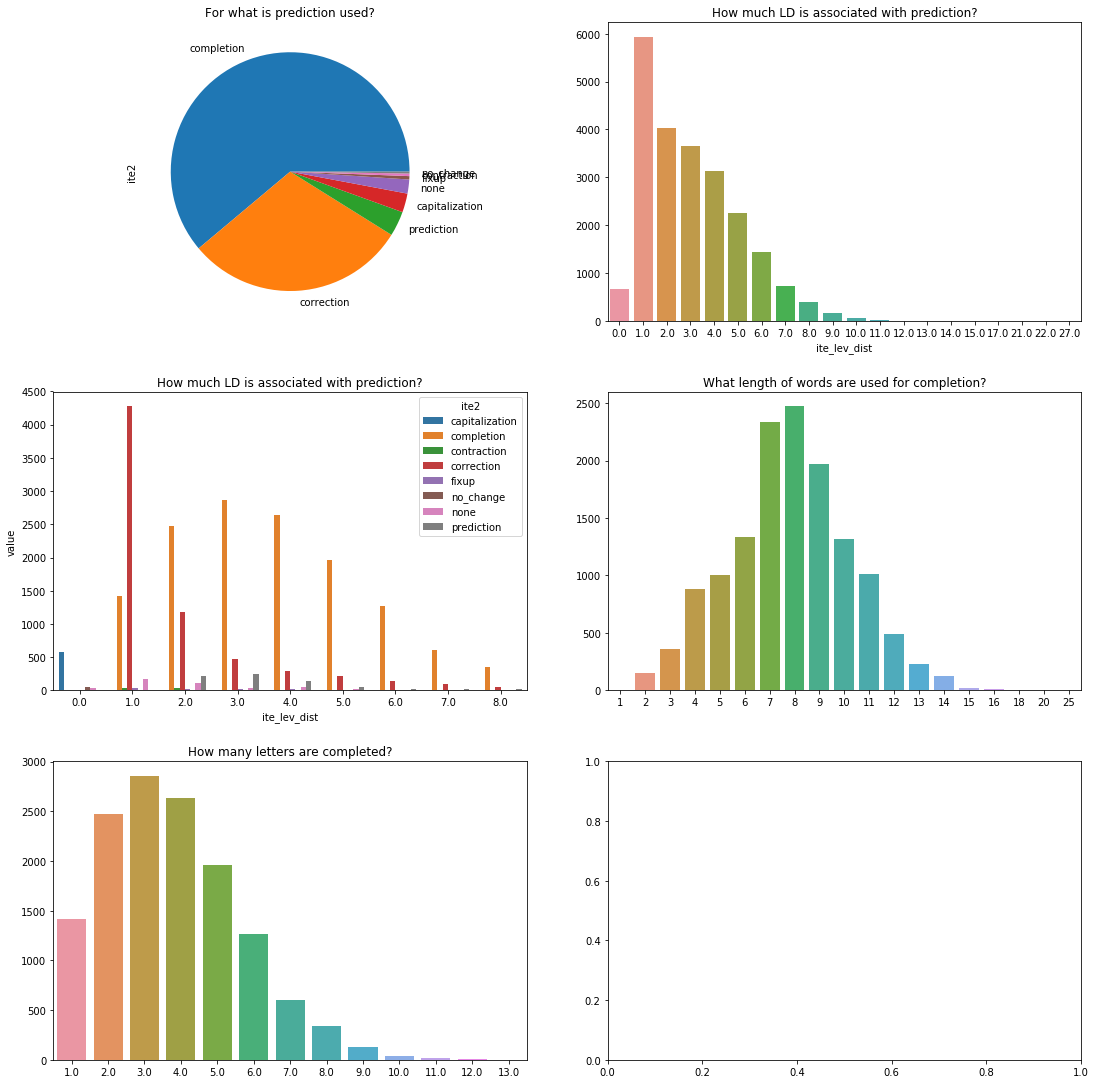

In [11]:
f,ax = plt.subplots(3,2,figsize=(15,15))
ax1,ax2,ax3,ax4,ax5,ax6=ax.flatten()

f.tight_layout(w_pad=5,h_pad=5)

ax1.set_title('For what is prediction used?')
data = words.loc[words.ite == 'predict']
data.ite2.value_counts(normalize=True).plot.pie(ax=ax1)
ax1.set_aspect('equal')

ax2.set_title('How much LD is associated with prediction?')
data = words.loc[words.ite == 'predict']
data = data.groupby('ite_lev_dist').size()
sns.barplot(data.index,data.values,ax=ax2)

ax3.set_title('How much LD is associated with prediction?')
data = words.loc[words.ite == 'predict']
data = data.loc[data.ite_lev_dist < 9]
data = data.groupby(['ite_lev_dist','ite2']).size().unstack().reset_index().melt('ite_lev_dist')
sns.barplot(data.ite_lev_dist,data.value,hue=data.ite2,ax=ax3)

ax4.set_title('What length of words are used for completion?')
data = words.loc[words.ite2 == 'completion']
data = data.ite_input.str.len().value_counts()
sns.barplot(data.index,data.values,ax=ax4)

ax5.set_title('How many letters are completed?')
data = words.loc[words.ite2 == 'completion']
data = data.ite_lev_dist.value_counts()
sns.barplot(data.index,data.values,ax=ax5)

### Is prediction used for certain words more than for others?

Text(63.125,0.5,'Probability')

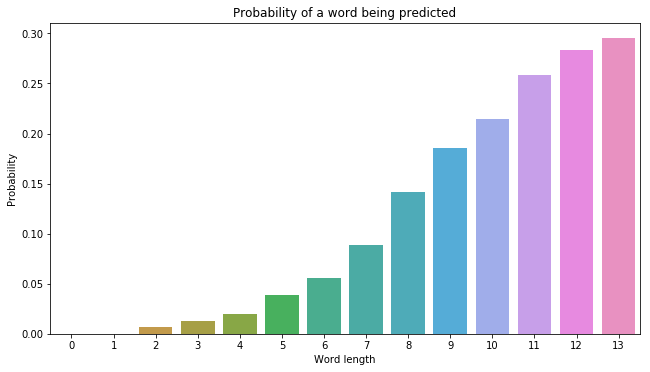

In [311]:
f,ax = plt.subplots(1,1,figsize=(10,6))
ax1 = ax

f.tight_layout(pad = 5)
ax1.set_title('Probability of a word being predicted')

# In the case of ITE, the input is equal to the final word
mask = (words.ite_input == words.word) | (words.ite == 'none')
# Very long words don't occur enough times to make a conclusion
data = words.loc[(words.word_length < 14) & mask]
data = data.groupby('word_length').ite.value_counts(normalize=True).unstack()['predict']
sns.barplot(data.index,data.values,ax=ax1)
ax1.set_xlabel('Word length')
ax1.set_ylabel('Probability')

In [ ]:
f.savefig('./figures/length_predict_probability.png',dpi=300)

Text(63.125,0.5,'Probability')

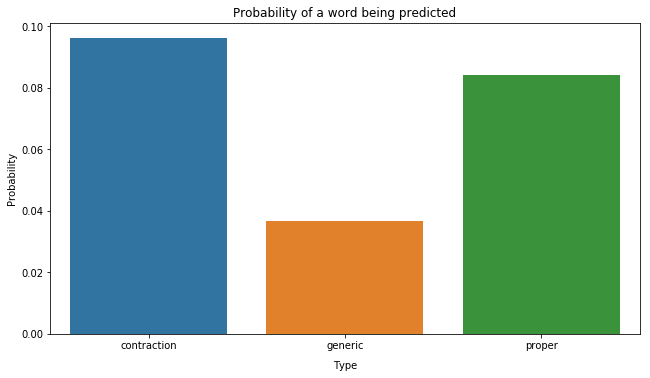

In [312]:
f,ax = plt.subplots(1,1,figsize=(10,6))
ax1 = ax

f.tight_layout(pad = 5)
ax1.set_title('Probability of a word being predicted')

# In the case of ITE, the input is equal to the final word
mask = (words.ite_input == words.word) | (words.ite == 'none')
# Very long words don't occur enough times to make a conclusion
data = words.loc[(words.word_length < 13) & mask]
data = data.groupby('type').ite.value_counts(normalize=True).unstack()['predict']
sns.barplot(data.index,data.values,ax=ax1)
ax1.set_xlabel('Type',labelpad=10)
ax1.set_ylabel('Probability')

In [ ]:
f.savefig('./figures/type_predict_probability.png',dpi=300)

Text(0,0.5,'Probability')

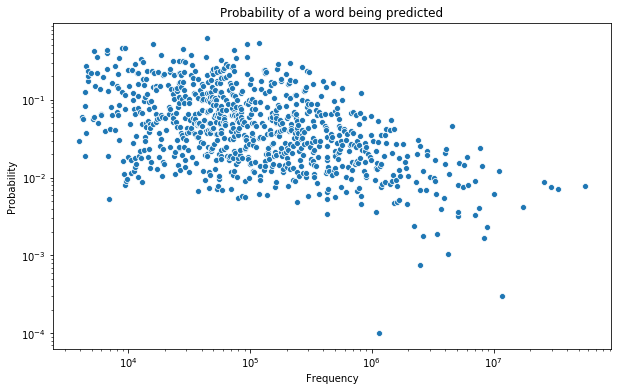

In [323]:
f,ax = plt.subplots(1,1,figsize=(10,6))
ax1 = ax

ax1.set_title('Probability of a word being predicted')
ax1.set_xscale('log')
ax1.set_yscale('log')

# In the case of ITE, the input is equal to the final word
mask = (words.ite_input == words.word) | (words.ite == 'none')
data = words.loc[(words.word_length < 13) & mask]
data = data.groupby('freq').ite.value_counts(normalize=True).unstack()['predict']
data = data.loc[words.groupby('freq').size() > 50]
data = data.reset_index()
sns.scatterplot(data.freq,data.predict,ax=ax1)

ax1.set_xlabel('Frequency')
ax1.set_ylabel('Probability')


In [ ]:
f.savefig('./figures/freq_predict_probability.png',dpi=300)

#### Measuring effort

In [13]:
qwerty = [
    'qwertyuiop',
    'asdfghjkl',
    'zxcvbnm'
]
tmp = qwerty
for i,line in enumerate(tmp):
    qwerty[i] = list(line)
    
tmp = qwerty
qwerty = {}
# Invert so we have indices
for i,line in enumerate(tmp):
    for j,char in enumerate(line):
        qwerty[char] = [i,j]
qwerty = pd.DataFrame(qwerty).T
# Offset the rows
qwerty.loc[qwerty[0] == 1, 1] += 0.5
qwerty.loc[qwerty[0] == 2, 1] += 1.5

qwerty_dist = spatial.distance_matrix(qwerty,qwerty,p=1)
qwerty_dist = pd.DataFrame(qwerty_dist,index=qwerty.index,columns=qwerty.index)

# Flatten
tmp = qwerty_dist.copy()
qwerty_dist = {}
for i in tmp.index:
    for j in tmp.columns:
        qwerty_dist[i+j] = tmp.loc[i,j]
        
qwerty_dist2 = qwerty[1].to_dict()

def get_effort1(x):
    d = 0
    for i,c in enumerate(x[1:]):
        d += qwerty_dist[x[i:i+2]]
    return d

def get_effort1_first3(x):
    for i,c in enumerate(x.word[1:4]):
        x['effort1_'+str(i)] = qwerty_dist[x.word[i:i+2]]
    return x

def get_effort2(x):
    d = 0
    for i,c in enumerate(x):
        d += qwerty_dist2[c]
    return d

def get_effort3(x):
    d = 0
    for c in ['q','a','z','p','l','m']:
        if c in x:
            d += 1
    return d

In [19]:
# mask &= words.word_length > 2
mask = words.iki_natural > 0
mask &= (words.word.str.contains('^[a-z]+$'))
mask &= (words.ite_input_prev.isna()) | (words.ite_input_prev.str.contains('^[a-z]+$'))
mask &= words.word_length < 13
data = words.loc[mask].copy()
data.ite2 = data.ite2.fillna('none')
data = data.groupby('word').filter(lambda x: x.shape[0] > 50)
data['effort1'] = data.word.map(get_effort1) / data.word_length
data['effort2'] = data.word.map(get_effort2) / data.word_length
data['effort1_prev'] = data.ite_input_prev.dropna().map(get_effort1) / data.ite_input_prev.dropna().str.len()
data['hands1'] = data.participant_id.map(participants_.hands1)
data['hands2'] = data.participant_id.map(participants_.hands2)

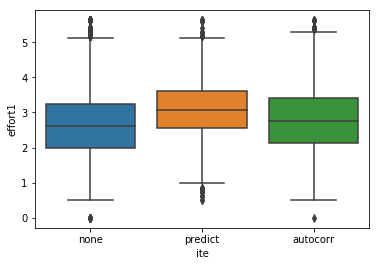

In [20]:
tmp = data.loc[data.hands1 == 'one_hand']
sns.boxplot('ite','effort1',data=tmp)

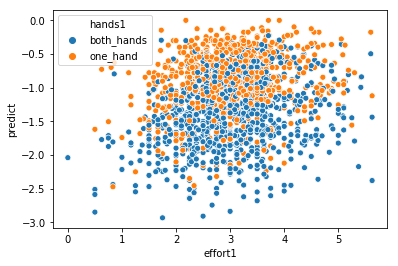

In [21]:
tmp = data.copy()
tmp = tmp.groupby(['word','effort1','effort2','hands1']).ite.value_counts(normalize=True).unstack()['predict']
tmp = tmp.reset_index()
tmp.predict = np.log10(tmp.predict)
sns.scatterplot('effort1','predict',data=tmp,hue='hands1')

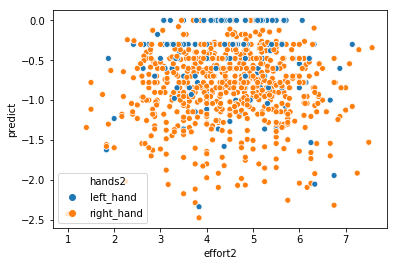

In [22]:
tmp = data.loc[data.hands1 == 'one_hand'].copy()
tmp = tmp.groupby(['word','effort1','effort2','hands2']).ite.value_counts(normalize=True).unstack()['predict']
tmp = tmp.reset_index().set_index('word')
tmp.predict = np.log10(tmp.predict)
sns.scatterplot('effort2','predict',data=tmp,hue='hands2')

### What is the probability of a word being predicted?

#### Multiple regression

In [416]:
qwerty = [
    'qwertyuiop',
    'asdfghjkl',
    'zxcvbnm'
]
tmp = qwerty
for i,line in enumerate(tmp):
    qwerty[i] = list(line)
    
tmp = qwerty
qwerty = {}
# Invert so we have indices
for i,line in enumerate(tmp):
    for j,char in enumerate(line):
        qwerty[char] = [i,j]
qwerty = pd.DataFrame(qwerty).T
# Offset the rows
qwerty.loc[qwerty[0] == 1, 1] += 0.5
qwerty.loc[qwerty[0] == 2, 1] += 1.5

qwerty_dist = spatial.distance_matrix(qwerty,qwerty,p=1)
qwerty_dist = pd.DataFrame(qwerty_dist,index=qwerty.index,columns=qwerty.index)

# Flatten
tmp = qwerty_dist.copy()
qwerty_dist = {}
for i in tmp.index:
    for j in tmp.columns:
        qwerty_dist[i+j] = tmp.loc[i,j]
        
qwerty_comfort_right = (4.5 - qwerty[1]).abs()
qwerty_comfort_left = 9 - qwerty_comfort_right
qwerty_comfort_both = qwerty_comfort_right

def get_effort(x):
    d = 0
    for i,c in enumerate(x[1:]):
        d += qwerty_dist[x[i:i+2]]
    return d

def get_comfort_right_hand(x):
    d = 0
    for c in x.word:
        d += qwerty_comfort_right.loc[c] 
    return d

def get_comfort_left_hand(x):
    d = 0
    for c in x.word:
        d += qwerty_comfort_left.loc[c] 
    return d

def get_comfort_both_hands(x):
    d = 0
    for c in x.word:
        d += qwerty_comfort_both.loc[c]         
    return d

In [508]:
mask = words.ite == 'none'
mask &= words.iki_natural > 0
mask &= words.word.str.contains('^[a-z]+$')
mask &= words.word_length < 14
data = words.loc[mask].copy()
data['hands2'] = data.participant_id.map(participants_.hands2)
data['comfort'] = data.apply(get_comfort,axis=1) / data.word_length

data = data.groupby('word').filter(lambda x: x.shape[0] > 40)
data = data.groupby('word')[['freq','word_length','iki_natural','comfort']].median()
data['effort'] = data.index.map(get_effort) / data.word_length

tmp = words.loc[(words.word == words.ite_input) | (words.ite == 'none')].copy()
data['probability'] = tmp.groupby('word').ite.value_counts(normalize=True).unstack()['predict']

data = data.dropna()
data.freq = np.log10(data.freq)
data.probability = np.log10(data.probability)

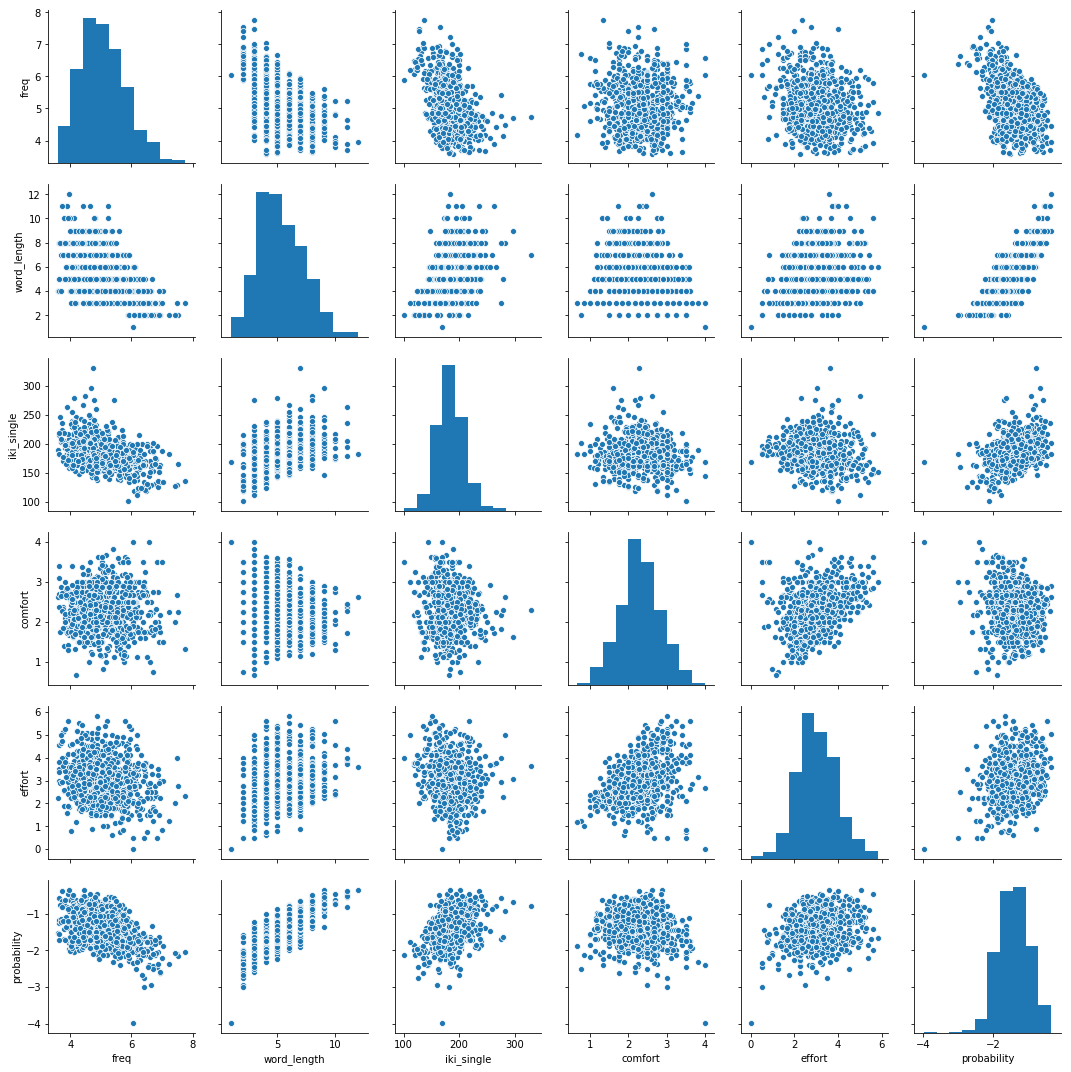

In [509]:
sns.pairplot(data)

In [520]:
X = data[['freq','word_length','iki_natural','effort','comfort']].copy()
X = preprocessing.StandardScaler().fit_transform(X)
y = data['probability'].copy()

X_train,X_test,y_train,y_test=model_selection.train_test_split(X,y,test_size=0.20,random_state=0)

reg = linear_model.LinearRegression()
reg.fit(X_train,y_train)
reg.score(X_test,y_test)

/Users/itto/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/itto/miniconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


0.6383167734157191

#### Logistic regression

In [70]:
mask = words.word_length > 1
mask &= words.word.str.contains('^[a-z]+$')
mask &= words.word_length < 14
data = words.loc[mask,['word','freq','word_length','iki_norm','iki_natural','ite']].copy()

data = data.loc[data.ite != 'autocorr']

data = data.groupby('word').filter(lambda x: x.shape[0] > 50)
data.iki_norm = data.word.map(data.groupby('word').iki_norm.median())
data.iki_natural = data.word.map(data.groupby('word').iki_natural.median())

data = data.dropna()
data.freq = np.log10(data.freq)
data = data.set_index('word')

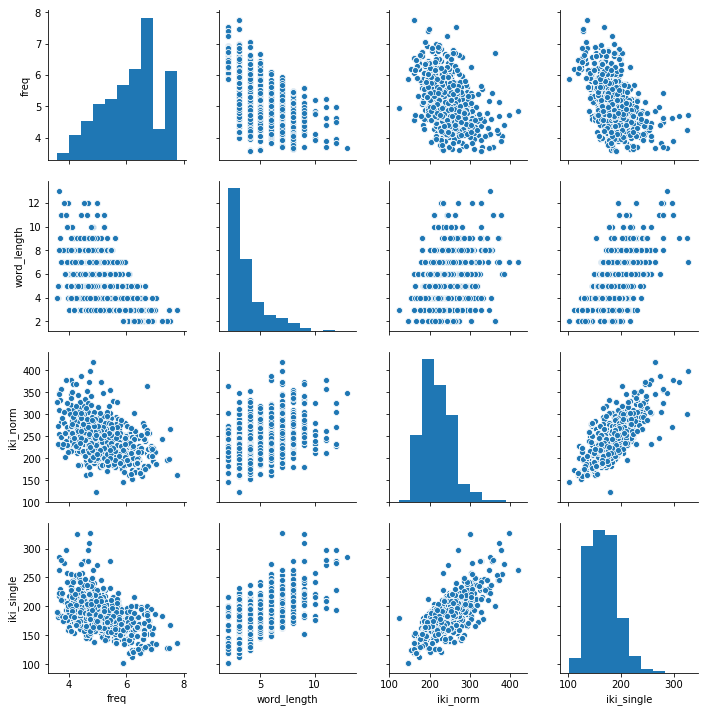

In [71]:
sns.pairplot(data.sample(10000,random_state=0))

In [129]:
X = data.loc[:,data.columns != 'ite'].copy()
X.word_length = X.word_length.astype(float)
X_scaled = preprocessing.StandardScaler().fit_transform(X)
X = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
y = data['ite'].copy()
X_train,X_test,y_train,y_test=model_selection.train_test_split(X,y,test_size=0.5,random_state=0)

reg = linear_model.LogisticRegression(solver='lbfgs',multi_class='ovr',max_iter=1000, fit_intercept=False)
reg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=1000, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [130]:
pd.DataFrame(reg.coef_,columns=X.columns) 

,freq,word_length,iki_norm,iki_single
0,0.055058,0.227926,0.057169,-0.005445


In [135]:
test = X_test.copy()
y_prob = reg.predict_proba(X_test)[:,1]
y_label = reg.predict(X_test)
test['prob'] = y_prob
test['label_pred'] = y_label
test['label_true'] = y_test

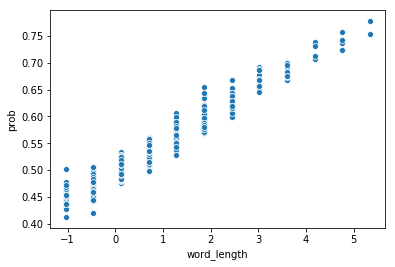

In [137]:
tmp = test.sample(10000)
tmp = tmp.groupby(tmp.index).mean()
sns.scatterplot(tmp.word_length, tmp.prob)

In [108]:
model = sm.MNLogit(y_train,X_train)
model = model.fit(maxiter=1000)

Optimization terminated successfully.
         Current function value: 0.687950
         Iterations 4


In [109]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                    ite   No. Observations:               154759
Model:                        MNLogit   Df Residuals:                   154755
Method:                           MLE   Df Model:                            3
Date:                Wed, 26 Jun 2019   Pseudo R-squ.:                  -3.513
Time:                        20:21:12   Log-Likelihood:            -1.0647e+05
converged:                       True   LL-Null:                       -23593.
                                        LLR p-value:                     1.000
===============================================================================
ite=predict       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
freq            0.0551      0.008      6.858      0.000       0.039       0.071
word_length     0.2279      0.008     28.844      0.000       0.212       0.243
iki_norm        0.0572      0.008      7.145      0.000       0.041       0.073
iki_single     -0.0055      0.009     -0.613      0.540      -0.023       0.012
===============================================================================
"""

In [132]:
y_pred = reg.predict(X_test)
confusion_matrix = pd.DataFrame(metrics.confusion_matrix(y_test,y_pred), index=reg.classes_,columns=reg.classes_)
confusion_matrix

,none,predict
none,100111,49188
predict,1388,4072


## Word clustering

In [ ]:
data = words.loc[words.ite == 'predict']
data = data.loc[data.ite_lev_ratio <= 1]

# Discretize
features_words = pd.DataFrame()
features_words['length'] = pd.cut(data.ite_input_len,[0,3,7,20],labels=['short','medium','long'])
features_words['freq'] = data.freq_category
features_words['ratio'] = pd.cut(data.ite_lev_ratio,[0,0.25,0.5,0.75,0.99,1])

# Other categoricals
features_words['ite2'] = data.ite2

# To dummy
features_words = pd.get_dummies(features_words)
features_words = features_words.astype('bool')
features_words = features_words.sample(1500)

# No standardization necessary
features_words_ss = features_words.copy()

In [ ]:
features_words_embedded = umap.UMAP(90,metric='jaccard',min_dist=0.01).fit_transform(features_words_ss)
features_words_embedded = pd.DataFrame(features_words_embedded,columns=['x','y'])

In [ ]:
f,ax = plt.subplots(5,4,figsize=(15,18))
ax = ax.flatten()

f.tight_layout(w_pad=3,h_pad=3)

sections = features_words_ss.columns

for i,section in enumerate(sections[:]):
    ax[i].scatter(
        features_words_embedded.x,
        features_words_embedded.y,
        c=features_words_ss[section],
        s=1,
    )
    ax[i].set_title(section)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

In [ ]:
f.savefig('/Users/itto/Downloads/umap_categorical_80_jaccard_001.svg',dpi=300)

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=40)
clusterer.fit(features_words_embedded)

features_words_embedded['label'] = clusterer.labels_
features_words_embedded['prob'] = clusterer.probabilities_

In [ ]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(15,6))

im = ax1.scatter(
    features_words_embedded.x,
    features_words_embedded.y,
    c=features_words_embedded.label,
    s = 5
)
ax1.set_aspect('equal')
ax1.set_xticks([])
ax1.set_yticks([])
f.colorbar(im,ax=ax1)

im = ax2.scatter(
    features_words_embedded.x,
    features_words_embedded.y,
    c=features_words_embedded.prob,
    cmap='copper',
    s = 5
)
ax2.set_aspect('equal')
ax2.set_xticks([])
ax2.set_yticks([])
f.colorbar(im,ax=ax2)

f.tight_layout()

In [ ]:
f.savefig('/Users/itto/Downloads/hdbscan_categorical_80_jaccard_001.svg',dpi=300)

In [ ]:
results = pd.DataFrame(index=features_words_ss.index)
results['label'] = features_words_embedded.label.values
results.label.value_counts()

In [ ]:
f,ax = plt.subplots(2,2,figsize=(15,8))
f.tight_layout(w_pad=5,h_pad=5)
ax = ax.flatten()

data = words.reindex(results.index).copy()

# 1
sns.stripplot(x=results.label,y=data.ite_input_len,ax=ax[0])
# 2
g = sns.boxplot(x=results.label,y=data.freq,ax=ax[1])
g.set_yscale('log')
# 3
data.groupby(results.label).freq_category.value_counts(normalize=True).unstack().plot.bar(stacked=True,ax=ax[2])
# 4
g = sns.stripplot(x=results.label,y=data.ite_lev_ratio,ax=ax[3])

In [ ]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(15,6))

sns.boxplot(x=results.label,y=data.iki_norm,ax=ax1)
ax1.set_ylim(0,800)

sns.boxplot(x=results.label,y=data.ite_iki,ax=ax2)
ax2.set_ylim(300,2000)

f.tight_layout()

In [ ]:
log.head(20)

## Measuring distance

In [ ]:
qwerty = [
    'qwertyuiop',
    'asdfghjkl',
    'zxcvbnm'
]
tmp = qwerty
for i,line in enumerate(tmp):
    qwerty[i] = list(line)

tmp = qwerty
qwerty = {}
# Invert so we have indices
for i,line in enumerate(tmp):
    for j,char in enumerate(line):
        qwerty[char] = [i,j]
qwerty = pd.DataFrame(qwerty).T
# Offset the rows
qwerty.loc[qwerty[0] == 1, 1] += 0.5
qwerty.loc[qwerty[0] == 2, 1] += 1.5

qwerty_dist = spatial.distance_matrix(qwerty,qwerty,p=1)
qwerty_dist = pd.DataFrame(qwerty_dist,index=qwerty.index,columns=qwerty.index)

# Flatten
tmp = qwerty_dist.copy()
qwerty_dist = {}
for i in tmp.index:
    for j in tmp.columns:
        qwerty_dist[i+j] = tmp.loc[i,j]

In [ ]:
from scipy import spatial

In [ ]:
mask = (log.key.str.len() == 1) & (log.key.shift(1).str.len() == 1)
mask &= (log.key.str.contains('[a-z]')) & (log.key.shift(1).str.contains('[a-z]'))

times = log.loc[mask,['text_field','key','iki','participant_id']]


participants = pd.read_csv('./data/participants.csv',sep='\t')
mask = participants.FINGERS.str.split(';').str[0] != 'both_hands'
times['hands'] = times.participant_id.map(participants.set_index('PARTICIPANT_ID').FINGERS.str.split(';').str[0])
times = times.loc[times.hands.isin(['left_hand','right_hand'])].copy()

In [ ]:
times.text_field = times.text_field.str[-2:]

In [ ]:
times['distance'] = times.text_field.map(qwerty_dist)

In [ ]:
f,ax = plt.subplots(1,1,figsize=(20,5))
data = times.loc[times.iki < 600]
sns.violinplot('distance','iki',data=data,ax=ax,hue='hands')

In [ ]:
qwerty_dist2 = qwerty[1].copy()

In [ ]:
times['distance2'] = times.key.map(qwerty_dist2)

In [ ]:
f,ax = plt.subplots(1,1,figsize=(20,5))
data = times.loc[times.iki < 600]
sns.violinplot('distance2','iki',data=data,ax=ax,hue='hands')

In [ ]:
f,ax = plt.subplots(1,1,figsize=(20,5))
data = times.loc[times.iki < 600].copy()
data = data.groupby(['participant_id','hands','distance']).iki.mean().reset_index()
sns.boxplot('distance','iki',data=data,ax=ax, hue='hands')

In [ ]:
f,ax = plt.subplots(1,1,figsize=(20,10))
data = times.loc[times.iki < 600].copy()
data = data.groupby(['participant_id','hands','distance2']).iki.mean().reset_index()
sns.boxplot('distance2','iki',data=data,ax=ax, hue='hands')

In [ ]:
times['pos_x'] = times.key.map(qwerty[1])
times['pos_y'] = times.key.map(qwerty[0])

In [ ]:
f,ax = plt.subplots(1,1,figsize=(5,3))
data = times.loc[times.iki < 2000].copy()
data = data.loc[data.hands == 'left_hand']
data = data.groupby([
    'key','pos_x','pos_y'
]).iki.mean().reset_index()
sns.scatterplot('pos_x','pos_y',data=data,ax=ax,size='iki',sizes=(10,300),legend=False)

In [ ]:
f,ax = plt.subplots(1,1,figsize=(5,3))
data = times.loc[times.iki < 2000].copy()
data = data.loc[data.hands == 'right_hand']
data = data.groupby([
    'key','pos_x','pos_y'
]).iki.mean().reset_index()
sns.scatterplot('pos_x','pos_y',data=data,ax=ax,size='iki',sizes=(10,300),legend=False)

## Letter counting

In [ ]:
from collections import Counter

In [ ]:
a = words.word.apply(Counter)

In [ ]:
a = pd.DataFrame.from_records(a)

In [ ]:
a['participant_id'] = words.participant_id
a['ts_id'] = words.ts_id
a['entry_id'] = words.entry_id
a.set_index(['participant_id','ts_id','entry_id'],inplace=True)

In [ ]:
a.fillna(0,inplace=True)
a = a.astype('int')

## Other

In [ ]:
f,ax = plt.subplots(1,1,figsize=(10,6))

mask = participants.n_predict > 6
pref = participants_ite2.loc[mask].idxmax(axis=1)
sns.stripplot(
    pref,
    participants_ite.loc[mask].predict
)

In [ ]:
f,ax = plt.subplots(1,1,figsize=(10,10))
mask = participants.n_predict > 5
data = participants_freq_relative.loc[participants_freq.ite == 'predict']
pref = data.max(axis=1)
sns.scatterplot(
    pref.loc[mask],
    participants_ite.loc[mask].predict,
    hue=data.drop('ite',axis=1).idxmax(axis=1),
    ax=ax
)

In [ ]:
f,ax = plt.subplots(2,2,figsize = (10,10))
f.tight_layout(w_pad=5,h_pad=5)

ax1,ax2,ax3,ax4=ax.flatten()

tmp = log.loc[log.ite2 == 'completion'].copy()
tmp['word_len'] = tmp.key.str.len()
tmp['completion_len'] = tmp.lev_dist
tmp['completion_ratio'] = tmp.completion_len/tmp.word_len

data = tmp.groupby('participant_id').word_len.median().to_frame('word_len')
data['completion_len'] = tmp.groupby('participant_id').completion_len.mean()
data['completion_ratio'] = tmp.groupby('participant_id').completion_ratio.mean()
data['rate'] = participants.rate_predict

sns.scatterplot(data.rate,data.word_len,data=data,ax=ax1)
sns.scatterplot(data.rate,data.completion_len,data=data,ax=ax2)
sns.scatterplot(data.rate,data.completion_ratio,data=data,ax=ax3)

In [ ]:
f,ax = plt.subplots(2,2,figsize = (10,10))
f.tight_layout(w_pad=5,h_pad=5)

ax1,ax2,ax3,ax4=ax.flatten()

data1 = words.loc[(words.word_length > 0) & (words.word_length < 13)]

data1.word_length.value_counts(normalize=True).sort_index().plot.bar(ax=ax1)

data1 = data1.loc[data1.ite == 'predict']
data1.loc[data1.participant_id == participants_ite.predict.idxmax()].word_length.value_counts().sort_index().plot.bar(ax=ax2)
data1.loc[data.participant_id == 86373].word_length.value_counts().sort_index().plot.bar(ax=ax3)

In [ ]:
data1.loc[data.participant_id == 184294].word_length.std()

In [ ]:
data1.loc[data1.participant_id == participants_ite.predict.idxmax()].word_length.std()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

fig = plt.figure()
ax = Axes3D(fig)

data = participants.loc[participants.n_predict > 4].copy()
ax.scatter(data.rate_completion, data.rate_correction, data.rate_predict)
ax.set_xlabel('Rate completion')
ax.set_ylabel('Rate correction')
ax.set_zlabel('Usage rate')
plt.show()

### Autocorrect and Prediction

In [ ]:
%matplotlib inline

f,ax = plt.subplots(1,2,figsize=(15,20))
ax1,ax2 = ax.flatten()

f.tight_layout(w_pad=5,h_pad=5)

ax1.set_title('Which ITEs are used?')
log.ite.value_counts(normalize=True).plot.pie(ax=ax1)
ax1.set_aspect('equal')

ax2.set_title('In what combinations are ITEs used?')
data = participants.loc[participants.n_predict + participants.n_autocorr >= 5]
sns.scatterplot(data.rate_predict,data.rate_autocorr,ax=ax2)
ax2.axis('scaled')

In [ ]:
%matplotlib inline
f,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(18,12))

data = participants.loc[participants.n_predict > 10].copy()

entropy_freq = data[[
    'rate_conjunction',
    'rate_uncommon',
    'rate_common',
    'rate_very_common'
]].apply(stats.entropy,axis=1)

log['key_len'] = log.key.str.len()
mask = (log.ite == 'predict') & (log.key_len <= 10) & (log.participant_id.isin(data.index.unique()))
entropy_len = log.loc[mask].groupby(['participant_id']).key_len.value_counts(normalize=True).unstack().fillna(0)
entropy_len = entropy_len.apply(stats.entropy,axis=1)
log.drop('key_len',axis=1,inplace=True)


entropy_ite2 = data[[
    'rate_completion',
    'rate_correction',
    'rate_correction2',
    'rate_none'
]].apply(stats.entropy,axis=1)

ax1.plot(data.rate_predict,entropy_freq,'k.')
ax2.plot(data.rate_predict,entropy_len,'k.')
ax3.plot(data.rate_predict,entropy_ite2,'k.')

In [ ]:
from importlib import reload
reload(plt)
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(entropy_freq, entropy_len, entropy_ite2)
ax.set_xlabel('Rate common')
ax.set_ylabel('Rate very common')
ax.set_zlabel('Rate conjunction')
plt.show()

## Buglist

#### Very fast predict/autocorrect keystroke is followed by a slow space keystroke

The prediction keystrokes can be even faster than 30ms. The true time it took theuser to press the suggestions box is actually reflected in the space button. What this means is that many predictions will not be caught because they are too fast. One very specific way of solving this is to check for very fast prediction keystrokes and then use the IKI of the space keystroke to check if it is an autocorrect (i.e., IKI is below a certain threshold) or prediction (above threhsold).

#### Incorrect Lev Dist

In [399]:
log_sample.loc[log_sample.ts_id == 50530].iloc[22:28]

,ts_id,key,text_field,lev_dist,input_len,timestamp,autocorr,predict,swype,participant_id
120943,50530,c,Both leading c,1,14,1537825235094,0,0,0,15071
120944,50530,a,Both leading ca,1,15,1537825235232,0,0,0,15071
120945,50530,n,Both leading can,1,16,1537825235394,0,0,0,15071
120946,50530,d,Both leading cand,1,17,1537825235685,0,0,0,15071
120947,50530,candidates,Both leading candidates,1,23,1537825236318,0,0,0,15071
120948,50530,,Both leading candidates,1,24,1537825236377,0,0,0,15071


#### Two different predict backend behaviours

There are two predict backend behaviours. The first one will register the entire word as the key (e.g. 'guilty'), the second will only register the completed portion (e.g. 'lty'). We analyze assuming the first behaviour, but we should correct the second behaviour to be consistent. Otherwise, many mentrics are incorrecxt (e.g. the word length is currently measured by just taking the length of the key, since it 

In [ ]:
mask = log.ite == 'predict'
mask &= (log.lev_dist == log.key.str.len())
log.loc[mask]

#### Multi-word inputs

Some participants exhibit a keyboard behaviour where the key contains current and previous words that were entered. Is this due to buggy key inference? Or is this some sort of software behaviour? Check the raw data.

In [ ]:
log.loc[(log.participant_id == 92275)].head(10)

In [ ]:
log.loc[log.key.str.findall(' ').apply(len) >= 3].participant_id.value_counts().head(8)

#### Repeated keys

Some participants using Swype will exhibit repeated keys (maybe due to the space added at the end of the word?). This results in double the Swype entries.

In [ ]:
log.loc[log.ts_id == 267609].head(10)

In [ ]:
log.loc[(log.key.str.strip(' ').str.len() > 1) & (log.key.shift(-1) == log.key)].participant_id.value_counts()

#### Consistent multicharacter inputs

Some participants have multicharacter inputs at the end of every word (or many words). These inputs have zero LD. This might be a side effect of having autocorrect turned on. Every time the user presses SPACE, the entire word is input, even if it was spelled correctly. This makes it hard to detect 0-LD predictions. 

In [ ]:
log.loc[log.ts_id == 1807755].head(20)

In [ ]:
mask = log.key.str.len() > 1
mask &= log.lev_dist == 0

log.loc[mask].participant_id.value_counts().hist(bins=70)

#### Overly broad completion condition

 Because the condition for completion is only that lev_dist == len_diff, then even if a letter is inserted into the middle of the word, this is considered a completion. For example, in the conjunction case: I-l-l becomes I'll. Or g-u-l-t-y becomes guilty. The former case can be argued to be a completion, but the latter is definitely not.

#### Overly strict prediction vs. correction classificaiton

Fuzziness between completion and correction subtypes ('ite2'). If somebody types 'g-i-u-l' and then completes to 'guilty', that's a completion. But currently we mark it as a correction because of the substitution between 'i-u' and 'u-i'.

#### Incorrect Levenshtein distance

Sometimes the Levenshtein distances appears to be incorrect. So far, this only seems to happen in the case of a backspace, where instead of 1, the Levenshtein distance is calculated as zero.

In [509]:
log.loc[log.ts_id == 68218].iloc[25:35]

,ts_id,entry_id,key,text_field,lev_dist,participant_id,len_diff,iki,text_field_prev,is_rep,ite,is_forward,iki_norm,tmp,ite2
160880,68218,2,h,Liverpool always h,1,19771,1,459.0,Liverpool always,False,none,True,459.0,False,None
160881,68218,2,a,Liverpool always ha,1,19771,1,85.0,Liverpool always h,False,none,True,85.0,False,None
160882,68218,2,s,Liverpool always has,1,19771,1,154.0,Liverpool always ha,False,none,True,154.0,False,None
160883,68218,-1,,Liverpool always has,2,19771,1,82.0,Liverpool always has,False,none,True,82.0,False,None
160884,68218,2,_,Liverpool always has,0,19771,-1,654.0,Liverpool always has,False,none,True,654.0,False,None
160885,68218,2,_,Liverpool always ha,1,19771,-1,133.0,Liverpool always has,False,none,True,133.0,False,None
160886,68218,2,d,Liverpool always had,1,19771,1,203.0,Liverpool always ha,False,none,True,203.0,False,None
160887,68218,-1,,Liverpool always had,1,19771,1,116.0,Liverpool always had,False,none,True,116.0,False,None
160888,68218,3,a,Liverpool always had a,1,19771,1,143.0,Liverpool always had,False,none,True,143.0,False,None
160889,68218,-1,,Liverpool always had a,1,19771,1,78.0,Liverpool always had a,False,none,True,78.0,False,None


In [512]:
log.loc[log.ts_id == 1658649].iloc[22:32]

,ts_id,entry_id,key,text_field,lev_dist,participant_id,len_diff,iki,text_field_prev,is_rep,ite,is_forward,iki_norm,tmp,ite2
3940511,1658649,-1,,Pilot Nick Young said,1,256028,1,219.0,Pilot Nick Young said,False,none,True,219.000000,False,None
3940512,1658649,4,c,Pilot Nick Young said c,1,256028,1,813.0,Pilot Nick Young said,False,none,True,813.000000,False,None
3940513,1658649,4,o,Pilot Nick Young said co,1,256028,1,234.0,Pilot Nick Young said c,False,none,True,234.000000,False,None
3940514,1658649,4,m,Pilot Nick Young said com,1,256028,1,218.0,Pilot Nick Young said co,False,none,True,218.000000,False,None
3940515,1658649,4,m,Pilot Nick Young said comm,1,256028,1,164.0,Pilot Nick Young said com,False,none,True,164.000000,False,None
3940516,1658649,4,u,Pilot Nick Young said commu,1,256028,1,1637.0,Pilot Nick Young said comm,False,none,True,1637.000000,False,None
3940517,1658649,4,n,Pilot Nick Young said commun,1,256028,1,249.0,Pilot Nick Young said commu,False,none,True,249.000000,False,None
3940518,1658649,4,i,Pilot Nick Young said communi,1,256028,1,1065.0,Pilot Nick Young said commun,False,none,True,1065.000000,False,None
3940519,1658649,4,c,Pilot Nick Young said communic,1,256028,1,399.0,Pilot Nick Young said communi,False,none,True,399.000000,False,None
3940520,1658649,4,communications,Pilot Nick Young said communications,27,256028,6,1203.0,Pilot Nick Young said communic,False,predict,True,85.928571,False,correction


#### Letters are not showing up in the log

In [ ]:
log.loc[(log.key.str.len() == 1) & (log.len_diff > 1) & (log.ts_id == 14038)]